# Afriat

In [1]:
ood_seed = 6

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [7]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('2.0', 'Pericentral', 'Uninfected')

Removed datapoint: 587


In [8]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [9]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = False,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: cnb1c1hd
Name: tusken-nerf-herder-169
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/cnb1c1hd
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_212225-cnb1c1hd/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2578,3294,8901
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2578,2601,1217,3375,1628,3374
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 3944,10829
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 627,815,2251
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 627,601,304,915,421,825
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1053,2640
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:12<2:04:19, 12.45s/it]

Epoch 1/600:   0%|          | 1/600 [00:12<2:04:19, 12.45s/it, v_num=hd_1, total_loss_train=3.68e+3, kl_local_train=52.7]

Epoch 2/600:   0%|          | 1/600 [00:12<2:04:19, 12.45s/it, v_num=hd_1, total_loss_train=3.68e+3, kl_local_train=52.7]

Epoch 2/600:   0%|          | 2/600 [00:23<1:56:56, 11.73s/it, v_num=hd_1, total_loss_train=3.68e+3, kl_local_train=52.7]

Epoch 2/600:   0%|          | 2/600 [00:23<1:56:56, 11.73s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=79]  

Epoch 3/600:   0%|          | 2/600 [00:23<1:56:56, 11.73s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=79]

Epoch 3/600:   0%|          | 3/600 [00:34<1:54:12, 11.48s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=79]

Epoch 3/600:   0%|          | 3/600 [00:34<1:54:12, 11.48s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=80.8]

Epoch 4/600:   0%|          | 3/600 [00:34<1:54:12, 11.48s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=80.8]

Epoch 4/600:   1%|          | 4/600 [00:46<1:52:42, 11.35s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=80.8]

Epoch 4/600:   1%|          | 4/600 [00:46<1:52:42, 11.35s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=78.1]

Epoch 5/600:   1%|          | 4/600 [00:46<1:52:42, 11.35s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=78.1]

Epoch 5/600:   1%|          | 5/600 [00:57<1:51:53, 11.28s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=78.1]

Epoch 5/600:   1%|          | 5/600 [00:57<1:51:53, 11.28s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=72.5]

Epoch 6/600:   1%|          | 5/600 [00:57<1:51:53, 11.28s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=72.5]

Epoch 6/600:   1%|          | 6/600 [01:08<1:51:12, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=72.5]

Epoch 6/600:   1%|          | 6/600 [01:08<1:51:12, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=63.3]

Epoch 7/600:   1%|          | 6/600 [01:08<1:51:12, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=63.3]

Epoch 7/600:   1%|          | 7/600 [01:19<1:51:13, 11.25s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=63.3]

Epoch 7/600:   1%|          | 7/600 [01:19<1:51:13, 11.25s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=50.2]

Epoch 8/600:   1%|          | 7/600 [01:19<1:51:13, 11.25s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=50.2]

Epoch 8/600:   1%|▏         | 8/600 [01:30<1:51:02, 11.25s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=50.2]

Epoch 8/600:   1%|▏         | 8/600 [01:30<1:51:02, 11.25s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=31.9] 

Epoch 9/600:   1%|▏         | 8/600 [01:30<1:51:02, 11.25s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=31.9]

Epoch 9/600:   2%|▏         | 9/600 [01:42<1:50:46, 11.25s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=31.9]

Epoch 9/600:   2%|▏         | 9/600 [01:42<1:50:46, 11.25s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=47.5]

Epoch 10/600:   2%|▏         | 9/600 [01:42<1:50:46, 11.25s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=47.5]

Epoch 10/600:   2%|▏         | 10/600 [01:53<1:50:29, 11.24s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=47.5]

Epoch 10/600:   2%|▏         | 10/600 [01:53<1:50:29, 11.24s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=96.8]

Epoch 11/600:   2%|▏         | 10/600 [01:53<1:50:29, 11.24s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=96.8]

Epoch 11/600:   2%|▏         | 11/600 [02:04<1:50:06, 11.22s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=96.8]

Epoch 11/600:   2%|▏         | 11/600 [02:04<1:50:06, 11.22s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=172] 

Epoch 12/600:   2%|▏         | 11/600 [02:04<1:50:06, 11.22s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=172]

Epoch 12/600:   2%|▏         | 12/600 [02:15<1:49:45, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=172]

Epoch 12/600:   2%|▏         | 12/600 [02:15<1:49:45, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=255]

Epoch 13/600:   2%|▏         | 12/600 [02:15<1:49:45, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=255]

Epoch 13/600:   2%|▏         | 13/600 [02:26<1:49:22, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=255]

Epoch 13/600:   2%|▏         | 13/600 [02:26<1:49:22, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=301] 

Epoch 14/600:   2%|▏         | 13/600 [02:26<1:49:22, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=301]

Epoch 14/600:   2%|▏         | 14/600 [02:37<1:49:09, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=301]

Epoch 14/600:   2%|▏         | 14/600 [02:37<1:49:09, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=354]

Epoch 15/600:   2%|▏         | 14/600 [02:37<1:49:09, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=354]

Epoch 15/600:   2%|▎         | 15/600 [02:49<1:49:14, 11.20s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=354]

Epoch 15/600:   2%|▎         | 15/600 [02:49<1:49:14, 11.20s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=404]

Epoch 16/600:   2%|▎         | 15/600 [02:49<1:49:14, 11.20s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=404]

Epoch 16/600:   3%|▎         | 16/600 [03:00<1:49:07, 11.21s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=404]

Epoch 16/600:   3%|▎         | 16/600 [03:00<1:49:07, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=482]

Epoch 17/600:   3%|▎         | 16/600 [03:00<1:49:07, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=482]

Epoch 17/600:   3%|▎         | 17/600 [03:11<1:49:03, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=482]

Epoch 17/600:   3%|▎         | 17/600 [03:11<1:49:03, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=579]

Epoch 18/600:   3%|▎         | 17/600 [03:11<1:49:03, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=579]

Epoch 18/600:   3%|▎         | 18/600 [03:22<1:48:56, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=579]

Epoch 18/600:   3%|▎         | 18/600 [03:22<1:48:56, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=652]

Epoch 19/600:   3%|▎         | 18/600 [03:22<1:48:56, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=652]

Epoch 19/600:   3%|▎         | 19/600 [03:34<1:48:47, 11.24s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=652]

Epoch 19/600:   3%|▎         | 19/600 [03:34<1:48:47, 11.24s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=640] 

Epoch 20/600:   3%|▎         | 19/600 [03:34<1:48:47, 11.24s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=640]

Epoch 20/600:   3%|▎         | 20/600 [03:45<1:48:33, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=640]

Epoch 20/600:   3%|▎         | 20/600 [03:45<1:48:33, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=635]

Epoch 21/600:   3%|▎         | 20/600 [03:45<1:48:33, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=635]

Epoch 21/600:   4%|▎         | 21/600 [03:56<1:48:22, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=635]

Epoch 21/600:   4%|▎         | 21/600 [03:56<1:48:22, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=599]

Epoch 22/600:   4%|▎         | 21/600 [03:56<1:48:22, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=599]

Epoch 22/600:   4%|▎         | 22/600 [04:07<1:48:09, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=599]

Epoch 22/600:   4%|▎         | 22/600 [04:07<1:48:09, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=560]

Epoch 23/600:   4%|▎         | 22/600 [04:07<1:48:09, 11.23s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=560]

Epoch 23/600:   4%|▍         | 23/600 [04:19<1:48:03, 11.24s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=560]

Epoch 23/600:   4%|▍         | 23/600 [04:19<1:48:03, 11.24s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=510]

Epoch 24/600:   4%|▍         | 23/600 [04:19<1:48:03, 11.24s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=510]

Epoch 24/600:   4%|▍         | 24/600 [04:30<1:47:54, 11.24s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=510]

Epoch 24/600:   4%|▍         | 24/600 [04:30<1:47:54, 11.24s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=531]

Epoch 25/600:   4%|▍         | 24/600 [04:30<1:47:54, 11.24s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=531]

Epoch 25/600:   4%|▍         | 25/600 [04:41<1:47:38, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=531]

Epoch 25/600:   4%|▍         | 25/600 [04:41<1:47:38, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=549]

Epoch 26/600:   4%|▍         | 25/600 [04:41<1:47:38, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=549]

Epoch 26/600:   4%|▍         | 26/600 [04:52<1:47:18, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=549]

Epoch 26/600:   4%|▍         | 26/600 [04:52<1:47:18, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=526]

Epoch 27/600:   4%|▍         | 26/600 [04:52<1:47:18, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=526]

Epoch 27/600:   4%|▍         | 27/600 [05:03<1:47:08, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=526]

Epoch 27/600:   4%|▍         | 27/600 [05:03<1:47:08, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=566]

Epoch 28/600:   4%|▍         | 27/600 [05:03<1:47:08, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=566]

Epoch 28/600:   5%|▍         | 28/600 [05:15<1:46:59, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=566]

Epoch 28/600:   5%|▍         | 28/600 [05:15<1:46:59, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=481]

Epoch 29/600:   5%|▍         | 28/600 [05:15<1:46:59, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=481]

Epoch 29/600:   5%|▍         | 29/600 [05:26<1:46:35, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=481]

Epoch 29/600:   5%|▍         | 29/600 [05:26<1:46:35, 11.20s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=457]

Epoch 30/600:   5%|▍         | 29/600 [05:26<1:46:35, 11.20s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=457]

Epoch 30/600:   5%|▌         | 30/600 [05:37<1:46:34, 11.22s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=457]

Epoch 30/600:   5%|▌         | 30/600 [05:37<1:46:34, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=461]

Epoch 31/600:   5%|▌         | 30/600 [05:37<1:46:34, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=461]

Epoch 31/600:   5%|▌         | 31/600 [05:48<1:46:26, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=461]

Epoch 31/600:   5%|▌         | 31/600 [05:48<1:46:26, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=366]

Epoch 32/600:   5%|▌         | 31/600 [05:48<1:46:26, 11.22s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=366]

Epoch 32/600:   5%|▌         | 32/600 [06:00<1:46:16, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=366]

Epoch 32/600:   5%|▌         | 32/600 [06:00<1:46:16, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=310]

Epoch 33/600:   5%|▌         | 32/600 [06:00<1:46:16, 11.23s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=310]

Epoch 33/600:   6%|▌         | 33/600 [06:11<1:45:54, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=310]

Epoch 33/600:   6%|▌         | 33/600 [06:11<1:45:54, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=268]

Epoch 34/600:   6%|▌         | 33/600 [06:11<1:45:54, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=268]

Epoch 34/600:   6%|▌         | 34/600 [06:22<1:45:46, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=268]

Epoch 34/600:   6%|▌         | 34/600 [06:22<1:45:46, 11.21s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=246]

Epoch 35/600:   6%|▌         | 34/600 [06:22<1:45:46, 11.21s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=246]

Epoch 35/600:   6%|▌         | 35/600 [06:33<1:45:32, 11.21s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=246]

Epoch 35/600:   6%|▌         | 35/600 [06:33<1:45:32, 11.21s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=233]

Epoch 36/600:   6%|▌         | 35/600 [06:33<1:45:32, 11.21s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=233]

Epoch 36/600:   6%|▌         | 36/600 [06:44<1:45:19, 11.20s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=233]

Epoch 36/600:   6%|▌         | 36/600 [06:44<1:45:19, 11.20s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=225]

Epoch 37/600:   6%|▌         | 36/600 [06:44<1:45:19, 11.20s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=225]

Epoch 37/600:   6%|▌         | 37/600 [06:56<1:45:40, 11.26s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=225]

Epoch 37/600:   6%|▌         | 37/600 [06:56<1:45:40, 11.26s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=225]

Epoch 38/600:   6%|▌         | 37/600 [06:56<1:45:40, 11.26s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=225]

Epoch 38/600:   6%|▋         | 38/600 [07:07<1:45:10, 11.23s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=225]

Epoch 38/600:   6%|▋         | 38/600 [07:07<1:45:10, 11.23s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=224]

Epoch 39/600:   6%|▋         | 38/600 [07:07<1:45:10, 11.23s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=224]

Epoch 39/600:   6%|▋         | 39/600 [07:18<1:44:50, 11.21s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=224]

Epoch 39/600:   6%|▋         | 39/600 [07:18<1:44:50, 11.21s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=222]

Epoch 40/600:   6%|▋         | 39/600 [07:18<1:44:50, 11.21s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=222]

Epoch 40/600:   7%|▋         | 40/600 [07:29<1:44:34, 11.20s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=222]

Epoch 40/600:   7%|▋         | 40/600 [07:29<1:44:34, 11.20s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=218]

Epoch 41/600:   7%|▋         | 40/600 [07:29<1:44:34, 11.20s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=218]

Epoch 41/600:   7%|▋         | 41/600 [07:40<1:44:15, 11.19s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=218]

Epoch 41/600:   7%|▋         | 41/600 [07:40<1:44:15, 11.19s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=219]

Epoch 42/600:   7%|▋         | 41/600 [07:40<1:44:15, 11.19s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=219]

Epoch 42/600:   7%|▋         | 42/600 [07:52<1:44:01, 11.19s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=219]

Epoch 42/600:   7%|▋         | 42/600 [07:52<1:44:01, 11.19s/it, v_num=hd_1, total_loss_train=3232.75, kl_local_train=211]

Epoch 43/600:   7%|▋         | 42/600 [07:52<1:44:01, 11.19s/it, v_num=hd_1, total_loss_train=3232.75, kl_local_train=211]

Epoch 43/600:   7%|▋         | 43/600 [08:03<1:43:49, 11.18s/it, v_num=hd_1, total_loss_train=3232.75, kl_local_train=211]

Epoch 43/600:   7%|▋         | 43/600 [08:03<1:43:49, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=215]

Epoch 44/600:   7%|▋         | 43/600 [08:03<1:43:49, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=215]

Epoch 44/600:   7%|▋         | 44/600 [08:14<1:43:35, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=215]

Epoch 44/600:   7%|▋         | 44/600 [08:14<1:43:35, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=221]

Epoch 45/600:   7%|▋         | 44/600 [08:14<1:43:35, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=221]

Epoch 45/600:   8%|▊         | 45/600 [08:25<1:43:19, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=221]

Epoch 45/600:   8%|▊         | 45/600 [08:25<1:43:19, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=220]

Epoch 46/600:   8%|▊         | 45/600 [08:25<1:43:19, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=220]

Epoch 46/600:   8%|▊         | 46/600 [08:36<1:43:11, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=220]

Epoch 46/600:   8%|▊         | 46/600 [08:36<1:43:11, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=219]

Epoch 47/600:   8%|▊         | 46/600 [08:36<1:43:11, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=219]

Epoch 47/600:   8%|▊         | 47/600 [08:47<1:42:57, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=219]

Epoch 47/600:   8%|▊         | 47/600 [08:47<1:42:57, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=216]

Epoch 48/600:   8%|▊         | 47/600 [08:47<1:42:57, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=216]

Epoch 48/600:   8%|▊         | 48/600 [08:59<1:42:46, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=216]

Epoch 48/600:   8%|▊         | 48/600 [08:59<1:42:46, 11.17s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 49/600:   8%|▊         | 48/600 [08:59<1:42:46, 11.17s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 49/600:   8%|▊         | 49/600 [09:10<1:42:44, 11.19s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 49/600:   8%|▊         | 49/600 [09:10<1:42:44, 11.19s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=214]

Epoch 50/600:   8%|▊         | 49/600 [09:10<1:42:44, 11.19s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=214]

Epoch 50/600:   8%|▊         | 50/600 [09:21<1:42:29, 11.18s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=214]

Epoch 50/600:   8%|▊         | 50/600 [09:21<1:42:29, 11.18s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=223]

Epoch 51/600:   8%|▊         | 50/600 [09:21<1:42:29, 11.18s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=223]

Epoch 51/600:   8%|▊         | 51/600 [09:32<1:42:14, 11.17s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=223]

Epoch 51/600:   8%|▊         | 51/600 [09:32<1:42:14, 11.17s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=216]

Epoch 52/600:   8%|▊         | 51/600 [09:32<1:42:14, 11.17s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=216]

Epoch 52/600:   9%|▊         | 52/600 [09:43<1:42:02, 11.17s/it, v_num=hd_1, total_loss_train=3.25e+3, kl_local_train=216]

Epoch 52/600:   9%|▊         | 52/600 [09:43<1:42:02, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=208]

Epoch 53/600:   9%|▊         | 52/600 [09:43<1:42:02, 11.17s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=208]

Epoch 53/600:   9%|▉         | 53/600 [09:55<1:41:56, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=208]

Epoch 53/600:   9%|▉         | 53/600 [09:55<1:41:56, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=206]

Epoch 54/600:   9%|▉         | 53/600 [09:55<1:41:56, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=206]

Epoch 54/600:   9%|▉         | 54/600 [10:06<1:41:51, 11.19s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=206]

Epoch 54/600:   9%|▉         | 54/600 [10:06<1:41:51, 11.19s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=212]

Epoch 55/600:   9%|▉         | 54/600 [10:06<1:41:51, 11.19s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=212]

Epoch 55/600:   9%|▉         | 55/600 [10:17<1:41:42, 11.20s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=212]

Epoch 55/600:   9%|▉         | 55/600 [10:17<1:41:42, 11.20s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=205]

Epoch 56/600:   9%|▉         | 55/600 [10:17<1:41:42, 11.20s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=205]

Epoch 56/600:   9%|▉         | 56/600 [10:28<1:41:23, 11.18s/it, v_num=hd_1, total_loss_train=3.24e+3, kl_local_train=205]

Epoch 56/600:   9%|▉         | 56/600 [10:28<1:41:23, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=199]

Epoch 57/600:   9%|▉         | 56/600 [10:28<1:41:23, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=199]

Epoch 57/600:  10%|▉         | 57/600 [10:39<1:41:10, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=199]

Epoch 57/600:  10%|▉         | 57/600 [10:39<1:41:10, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 58/600:  10%|▉         | 57/600 [10:39<1:41:10, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 58/600:  10%|▉         | 58/600 [10:50<1:40:57, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 58/600:  10%|▉         | 58/600 [10:50<1:40:57, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 59/600:  10%|▉         | 58/600 [10:50<1:40:57, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 59/600:  10%|▉         | 59/600 [11:02<1:40:43, 11.17s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=195]

Epoch 59/600:  10%|▉         | 59/600 [11:02<1:40:43, 11.17s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=190]

Epoch 60/600:  10%|▉         | 59/600 [11:02<1:40:43, 11.17s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=190]

Epoch 60/600:  10%|█         | 60/600 [11:13<1:40:38, 11.18s/it, v_num=hd_1, total_loss_train=3.23e+3, kl_local_train=190]

Epoch 60/600:  10%|█         | 60/600 [11:13<1:40:38, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=187]

Epoch 61/600:  10%|█         | 60/600 [11:13<1:40:38, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=187]

Epoch 61/600:  10%|█         | 61/600 [11:24<1:40:29, 11.19s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=187]

Epoch 61/600:  10%|█         | 61/600 [11:24<1:40:29, 11.19s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=177]

Epoch 62/600:  10%|█         | 61/600 [11:24<1:40:29, 11.19s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=177]

Epoch 62/600:  10%|█         | 62/600 [11:35<1:40:13, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=177]

Epoch 62/600:  10%|█         | 62/600 [11:35<1:40:13, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=175]

Epoch 63/600:  10%|█         | 62/600 [11:35<1:40:13, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=175]

Epoch 63/600:  10%|█         | 63/600 [11:46<1:40:03, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=175]

Epoch 63/600:  10%|█         | 63/600 [11:46<1:40:03, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 64/600:  10%|█         | 63/600 [11:46<1:40:03, 11.18s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 64/600:  11%|█         | 64/600 [11:58<1:40:14, 11.22s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 64/600:  11%|█         | 64/600 [11:58<1:40:14, 11.22s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 65/600:  11%|█         | 64/600 [11:58<1:40:14, 11.22s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 65/600:  11%|█         | 65/600 [12:09<1:39:55, 11.21s/it, v_num=hd_1, total_loss_train=3.22e+3, kl_local_train=172]

Epoch 65/600:  11%|█         | 65/600 [12:09<1:39:55, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=168]

Epoch 66/600:  11%|█         | 65/600 [12:09<1:39:55, 11.21s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=168]

Epoch 66/600:  11%|█         | 66/600 [12:20<1:39:42, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=168]

Epoch 66/600:  11%|█         | 66/600 [12:20<1:39:42, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=166]

Epoch 67/600:  11%|█         | 66/600 [12:20<1:39:42, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=166]

Epoch 67/600:  11%|█         | 67/600 [12:31<1:39:29, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=166]

Epoch 67/600:  11%|█         | 67/600 [12:31<1:39:29, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=165]

Epoch 68/600:  11%|█         | 67/600 [12:31<1:39:29, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=165]

Epoch 68/600:  11%|█▏        | 68/600 [12:42<1:39:17, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=165]

Epoch 68/600:  11%|█▏        | 68/600 [12:42<1:39:17, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=166]

Epoch 69/600:  11%|█▏        | 68/600 [12:42<1:39:17, 11.20s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=166]

Epoch 69/600:  12%|█▏        | 69/600 [12:54<1:39:03, 11.19s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=166]

Epoch 69/600:  12%|█▏        | 69/600 [12:54<1:39:03, 11.19s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 70/600:  12%|█▏        | 69/600 [12:54<1:39:03, 11.19s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 70/600:  12%|█▏        | 70/600 [13:05<1:38:50, 11.19s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=163]

Epoch 70/600:  12%|█▏        | 70/600 [13:05<1:38:50, 11.19s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=164]

Epoch 71/600:  12%|█▏        | 70/600 [13:05<1:38:50, 11.19s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=164]

Epoch 71/600:  12%|█▏        | 71/600 [13:16<1:38:40, 11.19s/it, v_num=hd_1, total_loss_train=3.21e+3, kl_local_train=164]

Epoch 71/600:  12%|█▏        | 71/600 [13:16<1:38:40, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=161] 

Epoch 72/600:  12%|█▏        | 71/600 [13:16<1:38:40, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=161]

Epoch 72/600:  12%|█▏        | 72/600 [13:27<1:38:29, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=161]

Epoch 72/600:  12%|█▏        | 72/600 [13:27<1:38:29, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 73/600:  12%|█▏        | 72/600 [13:27<1:38:29, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 73/600:  12%|█▏        | 73/600 [13:38<1:38:14, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 73/600:  12%|█▏        | 73/600 [13:38<1:38:14, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 74/600:  12%|█▏        | 73/600 [13:38<1:38:14, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 74/600:  12%|█▏        | 74/600 [13:50<1:37:58, 11.17s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=159]

Epoch 74/600:  12%|█▏        | 74/600 [13:50<1:37:58, 11.17s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=160]

Epoch 75/600:  12%|█▏        | 74/600 [13:50<1:37:58, 11.17s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=160]

Epoch 75/600:  12%|█▎        | 75/600 [14:01<1:37:53, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=160]

Epoch 75/600:  12%|█▎        | 75/600 [14:01<1:37:53, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 76/600:  12%|█▎        | 75/600 [14:01<1:37:53, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 76/600:  13%|█▎        | 76/600 [14:12<1:37:43, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=155]

Epoch 76/600:  13%|█▎        | 76/600 [14:12<1:37:43, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 77/600:  13%|█▎        | 76/600 [14:12<1:37:43, 11.19s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 77/600:  13%|█▎        | 77/600 [14:23<1:37:24, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=153]

Epoch 77/600:  13%|█▎        | 77/600 [14:23<1:37:24, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 78/600:  13%|█▎        | 77/600 [14:23<1:37:24, 11.18s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 78/600:  13%|█▎        | 78/600 [14:34<1:37:12, 11.17s/it, v_num=hd_1, total_loss_train=3.2e+3, kl_local_train=157]

Epoch 78/600:  13%|█▎        | 78/600 [14:34<1:37:12, 11.17s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=156]

Epoch 79/600:  13%|█▎        | 78/600 [14:34<1:37:12, 11.17s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=156]

Epoch 79/600:  13%|█▎        | 79/600 [14:45<1:37:06, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=156]

Epoch 79/600:  13%|█▎        | 79/600 [14:45<1:37:06, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=157]

Epoch 80/600:  13%|█▎        | 79/600 [14:45<1:37:06, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=157]

Epoch 80/600:  13%|█▎        | 80/600 [14:57<1:36:55, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=157]

Epoch 80/600:  13%|█▎        | 80/600 [14:57<1:36:55, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=154]

Epoch 81/600:  13%|█▎        | 80/600 [14:57<1:36:55, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=154]

Epoch 81/600:  14%|█▎        | 81/600 [15:08<1:36:51, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=154]

Epoch 81/600:  14%|█▎        | 81/600 [15:08<1:36:51, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=156]

Epoch 82/600:  14%|█▎        | 81/600 [15:08<1:36:51, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=156]

Epoch 82/600:  14%|█▎        | 82/600 [15:19<1:36:43, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=156]

Epoch 82/600:  14%|█▎        | 82/600 [15:19<1:36:43, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=155]

Epoch 83/600:  14%|█▎        | 82/600 [15:19<1:36:43, 11.20s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=155]

Epoch 83/600:  14%|█▍        | 83/600 [15:30<1:36:22, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=155]

Epoch 83/600:  14%|█▍        | 83/600 [15:30<1:36:22, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 84/600:  14%|█▍        | 83/600 [15:30<1:36:22, 11.18s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 84/600:  14%|█▍        | 84/600 [15:41<1:36:16, 11.19s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=153]

Epoch 84/600:  14%|█▍        | 84/600 [15:41<1:36:16, 11.19s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 84/600 [15:41<1:36:16, 11.19s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 85/600 [15:53<1:36:01, 11.19s/it, v_num=hd_1, total_loss_train=3.19e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 85/600 [15:53<1:36:01, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 86/600:  14%|█▍        | 85/600 [15:53<1:36:01, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 86/600:  14%|█▍        | 86/600 [16:04<1:35:43, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 86/600:  14%|█▍        | 86/600 [16:04<1:35:43, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 87/600:  14%|█▍        | 86/600 [16:04<1:35:43, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 87/600:  14%|█▍        | 87/600 [16:15<1:35:30, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 87/600:  14%|█▍        | 87/600 [16:15<1:35:30, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 88/600:  14%|█▍        | 87/600 [16:15<1:35:30, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 88/600:  15%|█▍        | 88/600 [16:26<1:35:16, 11.16s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=149]

Epoch 88/600:  15%|█▍        | 88/600 [16:26<1:35:16, 11.16s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 88/600 [16:26<1:35:16, 11.16s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 89/600 [16:37<1:35:04, 11.16s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 89/600 [16:37<1:35:04, 11.16s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=148]

Epoch 90/600:  15%|█▍        | 89/600 [16:37<1:35:04, 11.16s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=148]

Epoch 90/600:  15%|█▌        | 90/600 [16:48<1:34:57, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=148]

Epoch 90/600:  15%|█▌        | 90/600 [16:48<1:34:57, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 91/600:  15%|█▌        | 90/600 [16:48<1:34:57, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 91/600:  15%|█▌        | 91/600 [17:00<1:34:56, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=145]

Epoch 91/600:  15%|█▌        | 91/600 [17:00<1:34:56, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 92/600:  15%|█▌        | 91/600 [17:00<1:34:56, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 92/600:  15%|█▌        | 92/600 [17:11<1:34:43, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 92/600:  15%|█▌        | 92/600 [17:11<1:34:43, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 93/600:  15%|█▌        | 92/600 [17:11<1:34:43, 11.19s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 93/600:  16%|█▌        | 93/600 [17:22<1:34:29, 11.18s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 93/600:  16%|█▌        | 93/600 [17:22<1:34:29, 11.18s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 94/600:  16%|█▌        | 93/600 [17:22<1:34:29, 11.18s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 94/600:  16%|█▌        | 94/600 [17:33<1:34:14, 11.17s/it, v_num=hd_1, total_loss_train=3.18e+3, kl_local_train=144]

Epoch 94/600:  16%|█▌        | 94/600 [17:33<1:34:14, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 95/600:  16%|█▌        | 94/600 [17:33<1:34:14, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 95/600:  16%|█▌        | 95/600 [17:44<1:33:57, 11.16s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 95/600:  16%|█▌        | 95/600 [17:44<1:33:57, 11.16s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 96/600:  16%|█▌        | 95/600 [17:44<1:33:57, 11.16s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 96/600:  16%|█▌        | 96/600 [17:55<1:33:47, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 96/600:  16%|█▌        | 96/600 [17:55<1:33:47, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=145]

Epoch 97/600:  16%|█▌        | 96/600 [17:55<1:33:47, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=145]

Epoch 97/600:  16%|█▌        | 97/600 [18:07<1:33:39, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=145]

Epoch 97/600:  16%|█▌        | 97/600 [18:07<1:33:39, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=145]

Epoch 98/600:  16%|█▌        | 97/600 [18:07<1:33:39, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=145]

Epoch 98/600:  16%|█▋        | 98/600 [18:18<1:33:27, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=145]

Epoch 98/600:  16%|█▋        | 98/600 [18:18<1:33:27, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 99/600:  16%|█▋        | 98/600 [18:18<1:33:27, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 99/600:  16%|█▋        | 99/600 [18:29<1:33:18, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 99/600:  16%|█▋        | 99/600 [18:29<1:33:18, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 100/600:  16%|█▋        | 99/600 [18:29<1:33:18, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 100/600:  17%|█▋        | 100/600 [18:40<1:33:07, 11.18s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=144]

Epoch 100/600:  17%|█▋        | 100/600 [18:40<1:33:07, 11.18s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 101/600:  17%|█▋        | 100/600 [18:40<1:33:07, 11.18s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 101/600:  17%|█▋        | 101/600 [18:51<1:32:58, 11.18s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=142]

Epoch 101/600:  17%|█▋        | 101/600 [18:51<1:32:58, 11.18s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 102/600:  17%|█▋        | 101/600 [18:51<1:32:58, 11.18s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 102/600:  17%|█▋        | 102/600 [19:03<1:32:44, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 102/600:  17%|█▋        | 102/600 [19:03<1:32:44, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=141]

Epoch 103/600:  17%|█▋        | 102/600 [19:03<1:32:44, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=141]

Epoch 103/600:  17%|█▋        | 103/600 [19:14<1:32:30, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=141]

Epoch 103/600:  17%|█▋        | 103/600 [19:14<1:32:30, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 104/600:  17%|█▋        | 103/600 [19:14<1:32:30, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 104/600:  17%|█▋        | 104/600 [19:25<1:32:20, 11.17s/it, v_num=hd_1, total_loss_train=3.17e+3, kl_local_train=140]

Epoch 104/600:  17%|█▋        | 104/600 [19:25<1:32:20, 11.17s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=138]

Epoch 105/600:  17%|█▋        | 104/600 [19:25<1:32:20, 11.17s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=138]

Epoch 105/600:  18%|█▊        | 105/600 [19:36<1:32:06, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=138]

Epoch 105/600:  18%|█▊        | 105/600 [19:36<1:32:06, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 106/600:  18%|█▊        | 105/600 [19:36<1:32:06, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 106/600:  18%|█▊        | 106/600 [19:47<1:31:51, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 106/600:  18%|█▊        | 106/600 [19:47<1:31:51, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=138]

Epoch 107/600:  18%|█▊        | 106/600 [19:47<1:31:51, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=138]

Epoch 107/600:  18%|█▊        | 107/600 [19:58<1:31:38, 11.15s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=138]

Epoch 107/600:  18%|█▊        | 107/600 [19:58<1:31:38, 11.15s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 108/600:  18%|█▊        | 107/600 [19:58<1:31:38, 11.15s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 108/600:  18%|█▊        | 108/600 [20:09<1:31:30, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=137]

Epoch 108/600:  18%|█▊        | 108/600 [20:09<1:31:30, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 109/600:  18%|█▊        | 108/600 [20:09<1:31:30, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 109/600:  18%|█▊        | 109/600 [20:21<1:31:29, 11.18s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 109/600:  18%|█▊        | 109/600 [20:21<1:31:29, 11.18s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 110/600:  18%|█▊        | 109/600 [20:21<1:31:29, 11.18s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 110/600:  18%|█▊        | 110/600 [20:32<1:31:16, 11.18s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 110/600:  18%|█▊        | 110/600 [20:32<1:31:16, 11.18s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 111/600:  18%|█▊        | 110/600 [20:32<1:31:16, 11.18s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 111/600:  18%|█▊        | 111/600 [20:43<1:30:57, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=135]

Epoch 111/600:  18%|█▊        | 111/600 [20:43<1:30:57, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 112/600:  18%|█▊        | 111/600 [20:43<1:30:57, 11.16s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 112/600:  19%|█▊        | 112/600 [20:54<1:30:42, 11.15s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 112/600:  19%|█▊        | 112/600 [20:54<1:30:42, 11.15s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 113/600:  19%|█▊        | 112/600 [20:54<1:30:42, 11.15s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 113/600:  19%|█▉        | 113/600 [21:05<1:30:18, 11.13s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 113/600:  19%|█▉        | 113/600 [21:05<1:30:18, 11.13s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 114/600:  19%|█▉        | 113/600 [21:05<1:30:18, 11.13s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 114/600:  19%|█▉        | 114/600 [21:16<1:30:04, 11.12s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=134]

Epoch 114/600:  19%|█▉        | 114/600 [21:16<1:30:04, 11.12s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 115/600:  19%|█▉        | 114/600 [21:16<1:30:04, 11.12s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 115/600:  19%|█▉        | 115/600 [21:27<1:29:46, 11.11s/it, v_num=hd_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 115/600:  19%|█▉        | 115/600 [21:27<1:29:46, 11.11s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 116/600:  19%|█▉        | 115/600 [21:27<1:29:46, 11.11s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 116/600:  19%|█▉        | 116/600 [21:38<1:29:27, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 116/600:  19%|█▉        | 116/600 [21:38<1:29:27, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 117/600:  19%|█▉        | 116/600 [21:38<1:29:27, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 117/600:  20%|█▉        | 117/600 [21:49<1:29:11, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 117/600:  20%|█▉        | 117/600 [21:49<1:29:11, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 118/600:  20%|█▉        | 117/600 [21:49<1:29:11, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 118/600:  20%|█▉        | 118/600 [22:01<1:29:13, 11.11s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=130]

Epoch 118/600:  20%|█▉        | 118/600 [22:01<1:29:13, 11.11s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 119/600:  20%|█▉        | 118/600 [22:01<1:29:13, 11.11s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 119/600:  20%|█▉        | 119/600 [22:12<1:28:57, 11.10s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 119/600:  20%|█▉        | 119/600 [22:12<1:28:57, 11.10s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=132]

Epoch 120/600:  20%|█▉        | 119/600 [22:12<1:28:57, 11.10s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=132]

Epoch 120/600:  20%|██        | 120/600 [22:23<1:28:44, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=132]

Epoch 120/600:  20%|██        | 120/600 [22:23<1:28:44, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=128]

Epoch 121/600:  20%|██        | 120/600 [22:23<1:28:44, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=128]

Epoch 121/600:  20%|██        | 121/600 [22:34<1:28:31, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=128]

Epoch 121/600:  20%|██        | 121/600 [22:34<1:28:31, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 122/600:  20%|██        | 121/600 [22:34<1:28:31, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 122/600:  20%|██        | 122/600 [22:45<1:28:21, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 122/600:  20%|██        | 122/600 [22:45<1:28:21, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 123/600:  20%|██        | 122/600 [22:45<1:28:21, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 123/600:  20%|██        | 123/600 [22:56<1:28:06, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=129]

Epoch 123/600:  20%|██        | 123/600 [22:56<1:28:06, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=128]

Epoch 124/600:  20%|██        | 123/600 [22:56<1:28:06, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=128]

Epoch 124/600:  21%|██        | 124/600 [23:07<1:27:57, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=128]

Epoch 124/600:  21%|██        | 124/600 [23:07<1:27:57, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 125/600:  21%|██        | 124/600 [23:07<1:27:57, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 125/600:  21%|██        | 125/600 [23:18<1:27:46, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 125/600:  21%|██        | 125/600 [23:18<1:27:46, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 126/600:  21%|██        | 125/600 [23:18<1:27:46, 11.09s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 126/600:  21%|██        | 126/600 [23:29<1:27:33, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 126/600:  21%|██        | 126/600 [23:29<1:27:33, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=127]

Epoch 127/600:  21%|██        | 126/600 [23:29<1:27:33, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=127]

Epoch 127/600:  21%|██        | 127/600 [23:40<1:27:20, 11.08s/it, v_num=hd_1, total_loss_train=3.15e+3, kl_local_train=127]

Epoch 127/600:  21%|██        | 127/600 [23:40<1:27:20, 11.08s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=128]

Epoch 128/600:  21%|██        | 127/600 [23:40<1:27:20, 11.08s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=128]

Epoch 128/600:  21%|██▏       | 128/600 [23:51<1:27:05, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=128]

Epoch 128/600:  21%|██▏       | 128/600 [23:51<1:27:05, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=126]

Epoch 129/600:  21%|██▏       | 128/600 [23:51<1:27:05, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=126]

Epoch 129/600:  22%|██▏       | 129/600 [24:02<1:26:50, 11.06s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=126]

Epoch 129/600:  22%|██▏       | 129/600 [24:02<1:26:50, 11.06s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 130/600:  22%|██▏       | 129/600 [24:02<1:26:50, 11.06s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 130/600:  22%|██▏       | 130/600 [24:14<1:26:41, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=125]

Epoch 130/600:  22%|██▏       | 130/600 [24:14<1:26:41, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 130/600 [24:14<1:26:41, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 131/600 [24:25<1:26:32, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 131/600 [24:25<1:26:32, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 132/600:  22%|██▏       | 131/600 [24:25<1:26:32, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 132/600:  22%|██▏       | 132/600 [24:36<1:26:22, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 132/600:  22%|██▏       | 132/600 [24:36<1:26:22, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 133/600:  22%|██▏       | 132/600 [24:36<1:26:22, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 133/600:  22%|██▏       | 133/600 [24:47<1:26:17, 11.09s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 133/600:  22%|██▏       | 133/600 [24:47<1:26:17, 11.09s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 134/600:  22%|██▏       | 133/600 [24:47<1:26:17, 11.09s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 134/600:  22%|██▏       | 134/600 [24:58<1:25:58, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 134/600:  22%|██▏       | 134/600 [24:58<1:25:58, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 135/600:  22%|██▏       | 134/600 [24:58<1:25:58, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 135/600:  22%|██▎       | 135/600 [25:09<1:25:49, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 135/600:  22%|██▎       | 135/600 [25:09<1:25:49, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 136/600:  22%|██▎       | 135/600 [25:09<1:25:49, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 136/600:  23%|██▎       | 136/600 [25:20<1:25:42, 11.08s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=124]

Epoch 136/600:  23%|██▎       | 136/600 [25:20<1:25:42, 11.08s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 137/600:  23%|██▎       | 136/600 [25:20<1:25:42, 11.08s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 137/600:  23%|██▎       | 137/600 [25:31<1:25:24, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 137/600:  23%|██▎       | 137/600 [25:31<1:25:24, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 138/600:  23%|██▎       | 137/600 [25:31<1:25:24, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 138/600:  23%|██▎       | 138/600 [25:42<1:25:15, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=123]

Epoch 138/600:  23%|██▎       | 138/600 [25:42<1:25:15, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 138/600 [25:42<1:25:15, 11.07s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 139/600 [25:53<1:24:52, 11.05s/it, v_num=hd_1, total_loss_train=3.14e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 139/600 [25:53<1:24:52, 11.05s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=121]

Epoch 140/600:  23%|██▎       | 139/600 [25:53<1:24:52, 11.05s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=121]

Epoch 140/600:  23%|██▎       | 140/600 [26:04<1:24:47, 11.06s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=121]

Epoch 140/600:  23%|██▎       | 140/600 [26:04<1:24:47, 11.06s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 141/600:  23%|██▎       | 140/600 [26:04<1:24:47, 11.06s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 141/600:  24%|██▎       | 141/600 [26:15<1:24:39, 11.07s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 141/600:  24%|██▎       | 141/600 [26:15<1:24:39, 11.07s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 142/600:  24%|██▎       | 141/600 [26:15<1:24:39, 11.07s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 142/600:  24%|██▎       | 142/600 [26:27<1:26:27, 11.33s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 142/600:  24%|██▎       | 142/600 [26:27<1:26:27, 11.33s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 143/600:  24%|██▎       | 142/600 [26:27<1:26:27, 11.33s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 143/600:  24%|██▍       | 143/600 [26:38<1:25:39, 11.25s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=120]

Epoch 143/600:  24%|██▍       | 143/600 [26:38<1:25:39, 11.25s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 144/600:  24%|██▍       | 143/600 [26:38<1:25:39, 11.25s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 144/600:  24%|██▍       | 144/600 [26:49<1:25:02, 11.19s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 144/600:  24%|██▍       | 144/600 [26:49<1:25:02, 11.19s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 145/600:  24%|██▍       | 144/600 [26:49<1:25:02, 11.19s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 145/600:  24%|██▍       | 145/600 [27:01<1:24:49, 11.19s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 145/600:  24%|██▍       | 145/600 [27:01<1:24:49, 11.19s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 146/600:  24%|██▍       | 145/600 [27:01<1:24:49, 11.19s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 146/600:  24%|██▍       | 146/600 [27:12<1:24:21, 11.15s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 146/600:  24%|██▍       | 146/600 [27:12<1:24:21, 11.15s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 147/600:  24%|██▍       | 146/600 [27:12<1:24:21, 11.15s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 147/600:  24%|██▍       | 147/600 [27:23<1:24:01, 11.13s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 147/600:  24%|██▍       | 147/600 [27:23<1:24:01, 11.13s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 148/600:  24%|██▍       | 147/600 [27:23<1:24:01, 11.13s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 148/600:  25%|██▍       | 148/600 [27:34<1:23:36, 11.10s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=119]

Epoch 148/600:  25%|██▍       | 148/600 [27:34<1:23:36, 11.10s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 149/600:  25%|██▍       | 148/600 [27:34<1:23:36, 11.10s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 149/600:  25%|██▍       | 149/600 [27:45<1:23:12, 11.07s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=118]

Epoch 149/600:  25%|██▍       | 149/600 [27:45<1:23:12, 11.07s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 150/600:  25%|██▍       | 149/600 [27:45<1:23:12, 11.07s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 150/600:  25%|██▌       | 150/600 [27:56<1:22:49, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 150/600:  25%|██▌       | 150/600 [27:56<1:22:49, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 151/600:  25%|██▌       | 150/600 [27:56<1:22:49, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 151/600:  25%|██▌       | 151/600 [28:07<1:22:41, 11.05s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 151/600:  25%|██▌       | 151/600 [28:07<1:22:41, 11.05s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 152/600:  25%|██▌       | 151/600 [28:07<1:22:41, 11.05s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 152/600:  25%|██▌       | 152/600 [28:18<1:22:27, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 152/600:  25%|██▌       | 152/600 [28:18<1:22:27, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 153/600:  25%|██▌       | 152/600 [28:18<1:22:27, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 153/600:  26%|██▌       | 153/600 [28:29<1:22:16, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 153/600:  26%|██▌       | 153/600 [28:29<1:22:16, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 154/600:  26%|██▌       | 153/600 [28:29<1:22:16, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 154/600:  26%|██▌       | 154/600 [28:40<1:22:05, 11.04s/it, v_num=hd_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 154/600:  26%|██▌       | 154/600 [28:40<1:22:05, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 155/600:  26%|██▌       | 154/600 [28:40<1:22:05, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 155/600:  26%|██▌       | 155/600 [28:51<1:21:55, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 155/600:  26%|██▌       | 155/600 [28:51<1:21:55, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 156/600:  26%|██▌       | 155/600 [28:51<1:21:55, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 156/600:  26%|██▌       | 156/600 [29:02<1:21:45, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 156/600:  26%|██▌       | 156/600 [29:02<1:21:45, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 157/600:  26%|██▌       | 156/600 [29:02<1:21:45, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 157/600:  26%|██▌       | 157/600 [29:13<1:21:34, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 157/600:  26%|██▌       | 157/600 [29:13<1:21:34, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 158/600:  26%|██▌       | 157/600 [29:13<1:21:34, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 158/600:  26%|██▋       | 158/600 [29:24<1:21:18, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 158/600:  26%|██▋       | 158/600 [29:24<1:21:18, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 159/600:  26%|██▋       | 158/600 [29:24<1:21:18, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 159/600:  26%|██▋       | 159/600 [29:35<1:21:08, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 159/600:  26%|██▋       | 159/600 [29:35<1:21:08, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 160/600:  26%|██▋       | 159/600 [29:35<1:21:08, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 160/600:  27%|██▋       | 160/600 [29:46<1:20:56, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 160/600:  27%|██▋       | 160/600 [29:46<1:20:56, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 161/600:  27%|██▋       | 160/600 [29:46<1:20:56, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 161/600:  27%|██▋       | 161/600 [29:57<1:20:45, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 161/600:  27%|██▋       | 161/600 [29:57<1:20:45, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 162/600:  27%|██▋       | 161/600 [29:57<1:20:45, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 162/600:  27%|██▋       | 162/600 [30:08<1:20:37, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=115]

Epoch 162/600:  27%|██▋       | 162/600 [30:08<1:20:37, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 163/600:  27%|██▋       | 162/600 [30:08<1:20:37, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 163/600:  27%|██▋       | 163/600 [30:19<1:20:28, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 163/600:  27%|██▋       | 163/600 [30:19<1:20:28, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 164/600:  27%|██▋       | 163/600 [30:19<1:20:28, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 164/600:  27%|██▋       | 164/600 [30:30<1:20:21, 11.06s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 164/600:  27%|██▋       | 164/600 [30:30<1:20:21, 11.06s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 165/600:  27%|██▋       | 164/600 [30:30<1:20:21, 11.06s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 165/600:  28%|██▊       | 165/600 [30:41<1:20:02, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 165/600:  28%|██▊       | 165/600 [30:41<1:20:02, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 166/600:  28%|██▊       | 165/600 [30:41<1:20:02, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 166/600:  28%|██▊       | 166/600 [30:52<1:19:50, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 166/600:  28%|██▊       | 166/600 [30:52<1:19:50, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 167/600:  28%|██▊       | 166/600 [30:52<1:19:50, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 167/600:  28%|██▊       | 167/600 [31:03<1:19:43, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=113]

Epoch 167/600:  28%|██▊       | 167/600 [31:03<1:19:43, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 168/600:  28%|██▊       | 167/600 [31:03<1:19:43, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 168/600:  28%|██▊       | 168/600 [31:14<1:19:29, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 168/600:  28%|██▊       | 168/600 [31:14<1:19:29, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 168/600 [31:14<1:19:29, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 169/600 [31:26<1:19:18, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 169/600 [31:26<1:19:18, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 170/600:  28%|██▊       | 169/600 [31:26<1:19:18, 11.04s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 170/600:  28%|██▊       | 170/600 [31:37<1:19:09, 11.05s/it, v_num=hd_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 170/600:  28%|██▊       | 170/600 [31:37<1:19:09, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 171/600:  28%|██▊       | 170/600 [31:37<1:19:09, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 171/600:  28%|██▊       | 171/600 [31:48<1:19:03, 11.06s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=112]

Epoch 171/600:  28%|██▊       | 171/600 [31:48<1:19:03, 11.06s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 172/600:  28%|██▊       | 171/600 [31:48<1:19:03, 11.06s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 172/600:  29%|██▊       | 172/600 [31:59<1:18:55, 11.06s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 172/600:  29%|██▊       | 172/600 [31:59<1:18:55, 11.06s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 173/600:  29%|██▊       | 172/600 [31:59<1:18:55, 11.06s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 173/600:  29%|██▉       | 173/600 [32:10<1:18:55, 11.09s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 173/600:  29%|██▉       | 173/600 [32:10<1:18:55, 11.09s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 174/600:  29%|██▉       | 173/600 [32:10<1:18:55, 11.09s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 174/600:  29%|██▉       | 174/600 [32:21<1:18:41, 11.08s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 174/600:  29%|██▉       | 174/600 [32:21<1:18:41, 11.08s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 174/600 [32:21<1:18:41, 11.08s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 175/600 [32:32<1:18:27, 11.08s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 175/600 [32:32<1:18:27, 11.08s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 176/600:  29%|██▉       | 175/600 [32:32<1:18:27, 11.08s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 176/600:  29%|██▉       | 176/600 [32:43<1:18:12, 11.07s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 176/600:  29%|██▉       | 176/600 [32:43<1:18:12, 11.07s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 177/600:  29%|██▉       | 176/600 [32:43<1:18:12, 11.07s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 177/600:  30%|██▉       | 177/600 [32:54<1:18:00, 11.07s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 177/600:  30%|██▉       | 177/600 [32:54<1:18:00, 11.07s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 178/600:  30%|██▉       | 177/600 [32:54<1:18:00, 11.07s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 178/600:  30%|██▉       | 178/600 [33:05<1:17:43, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=111]

Epoch 178/600:  30%|██▉       | 178/600 [33:05<1:17:43, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 179/600:  30%|██▉       | 178/600 [33:05<1:17:43, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 179/600:  30%|██▉       | 179/600 [33:16<1:17:26, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=110]

Epoch 179/600:  30%|██▉       | 179/600 [33:16<1:17:26, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 180/600:  30%|██▉       | 179/600 [33:16<1:17:26, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 180/600:  30%|███       | 180/600 [33:27<1:17:10, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=109]

Epoch 180/600:  30%|███       | 180/600 [33:27<1:17:10, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 181/600:  30%|███       | 180/600 [33:27<1:17:10, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 181/600:  30%|███       | 181/600 [33:38<1:17:05, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 181/600:  30%|███       | 181/600 [33:38<1:17:05, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 182/600:  30%|███       | 181/600 [33:38<1:17:05, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 182/600:  30%|███       | 182/600 [33:49<1:16:52, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 182/600:  30%|███       | 182/600 [33:49<1:16:52, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 183/600:  30%|███       | 182/600 [33:49<1:16:52, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 183/600:  30%|███       | 183/600 [34:00<1:16:45, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 183/600:  30%|███       | 183/600 [34:00<1:16:45, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 184/600:  30%|███       | 183/600 [34:00<1:16:45, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 184/600:  31%|███       | 184/600 [34:11<1:16:30, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 184/600:  31%|███       | 184/600 [34:11<1:16:30, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 185/600:  31%|███       | 184/600 [34:11<1:16:30, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 185/600:  31%|███       | 185/600 [34:22<1:16:22, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 185/600:  31%|███       | 185/600 [34:22<1:16:22, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 186/600:  31%|███       | 185/600 [34:22<1:16:22, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 186/600:  31%|███       | 186/600 [34:33<1:16:09, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 186/600:  31%|███       | 186/600 [34:33<1:16:09, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 187/600:  31%|███       | 186/600 [34:33<1:16:09, 11.04s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 187/600:  31%|███       | 187/600 [34:44<1:15:56, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 187/600:  31%|███       | 187/600 [34:44<1:15:56, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 188/600:  31%|███       | 187/600 [34:44<1:15:56, 11.03s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 188/600:  31%|███▏      | 188/600 [34:55<1:15:50, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 188/600:  31%|███▏      | 188/600 [34:55<1:15:50, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 189/600:  31%|███▏      | 188/600 [34:56<1:15:50, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 189/600:  32%|███▏      | 189/600 [35:07<1:15:43, 11.05s/it, v_num=hd_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 189/600:  32%|███▏      | 189/600 [35:07<1:15:43, 11.05s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=108] 

Epoch 190/600:  32%|███▏      | 189/600 [35:07<1:15:43, 11.05s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 190/600:  32%|███▏      | 190/600 [35:18<1:15:29, 11.05s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=108]

Epoch 190/600:  32%|███▏      | 190/600 [35:18<1:15:29, 11.05s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 191/600:  32%|███▏      | 190/600 [35:18<1:15:29, 11.05s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 191/600:  32%|███▏      | 191/600 [35:29<1:15:12, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 191/600:  32%|███▏      | 191/600 [35:29<1:15:12, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 192/600:  32%|███▏      | 191/600 [35:29<1:15:12, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 192/600:  32%|███▏      | 192/600 [35:40<1:14:59, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 192/600:  32%|███▏      | 192/600 [35:40<1:14:59, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 192/600 [35:40<1:14:59, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 193/600 [35:51<1:14:53, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 193/600 [35:51<1:14:53, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 194/600:  32%|███▏      | 193/600 [35:51<1:14:53, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 194/600:  32%|███▏      | 194/600 [36:02<1:14:40, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 194/600:  32%|███▏      | 194/600 [36:02<1:14:40, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 195/600:  32%|███▏      | 194/600 [36:02<1:14:40, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 195/600:  32%|███▎      | 195/600 [36:13<1:14:23, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 195/600:  32%|███▎      | 195/600 [36:13<1:14:23, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 196/600:  32%|███▎      | 195/600 [36:13<1:14:23, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 196/600:  33%|███▎      | 196/600 [36:24<1:14:13, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 196/600:  33%|███▎      | 196/600 [36:24<1:14:13, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 197/600:  33%|███▎      | 196/600 [36:24<1:14:13, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 197/600:  33%|███▎      | 197/600 [36:35<1:14:01, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 197/600:  33%|███▎      | 197/600 [36:35<1:14:01, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 198/600:  33%|███▎      | 197/600 [36:35<1:14:01, 11.02s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 198/600:  33%|███▎      | 198/600 [36:46<1:13:46, 11.01s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 198/600:  33%|███▎      | 198/600 [36:46<1:13:46, 11.01s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 199/600:  33%|███▎      | 198/600 [36:46<1:13:46, 11.01s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 199/600:  33%|███▎      | 199/600 [36:57<1:13:36, 11.01s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=106]

Epoch 199/600:  33%|███▎      | 199/600 [36:57<1:13:36, 11.01s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 199/600 [36:57<1:13:36, 11.01s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 200/600 [37:08<1:13:34, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 200/600 [37:08<1:13:34, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 201/600:  33%|███▎      | 200/600 [37:08<1:13:34, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 201/600:  34%|███▎      | 201/600 [37:19<1:13:32, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=105]

Epoch 201/600:  34%|███▎      | 201/600 [37:19<1:13:32, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 202/600:  34%|███▎      | 201/600 [37:19<1:13:32, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 202/600:  34%|███▎      | 202/600 [37:30<1:13:20, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 202/600:  34%|███▎      | 202/600 [37:30<1:13:20, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 203/600:  34%|███▎      | 202/600 [37:30<1:13:20, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 203/600:  34%|███▍      | 203/600 [37:41<1:13:08, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 203/600:  34%|███▍      | 203/600 [37:41<1:13:08, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 204/600:  34%|███▍      | 203/600 [37:41<1:13:08, 11.06s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 204/600:  34%|███▍      | 204/600 [37:52<1:12:46, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 204/600:  34%|███▍      | 204/600 [37:52<1:12:46, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 205/600:  34%|███▍      | 204/600 [37:52<1:12:46, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 205/600:  34%|███▍      | 205/600 [38:03<1:12:40, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 205/600:  34%|███▍      | 205/600 [38:03<1:12:40, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 206/600:  34%|███▍      | 205/600 [38:03<1:12:40, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 206/600:  34%|███▍      | 206/600 [38:14<1:12:30, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 206/600:  34%|███▍      | 206/600 [38:14<1:12:30, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 207/600:  34%|███▍      | 206/600 [38:14<1:12:30, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 207/600:  34%|███▍      | 207/600 [38:25<1:12:17, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 207/600:  34%|███▍      | 207/600 [38:25<1:12:17, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 208/600:  34%|███▍      | 207/600 [38:25<1:12:17, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 208/600:  35%|███▍      | 208/600 [38:36<1:12:07, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 208/600:  35%|███▍      | 208/600 [38:36<1:12:07, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 208/600 [38:36<1:12:07, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 209/600 [38:47<1:11:53, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 209/600 [38:47<1:11:53, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 210/600:  35%|███▍      | 209/600 [38:47<1:11:53, 11.03s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 210/600:  35%|███▌      | 210/600 [38:58<1:11:43, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 210/600:  35%|███▌      | 210/600 [38:58<1:11:43, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 211/600:  35%|███▌      | 210/600 [38:58<1:11:43, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 211/600:  35%|███▌      | 211/600 [39:09<1:11:36, 11.04s/it, v_num=hd_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 211/600:  35%|███▌      | 211/600 [39:09<1:11:36, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 212/600:  35%|███▌      | 211/600 [39:09<1:11:36, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 212/600:  35%|███▌      | 212/600 [39:20<1:11:27, 11.05s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 212/600:  35%|███▌      | 212/600 [39:20<1:11:27, 11.05s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 213/600:  35%|███▌      | 212/600 [39:20<1:11:27, 11.05s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 213/600:  36%|███▌      | 213/600 [39:31<1:11:10, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 213/600:  36%|███▌      | 213/600 [39:31<1:11:10, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 214/600:  36%|███▌      | 213/600 [39:31<1:11:10, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 214/600:  36%|███▌      | 214/600 [39:42<1:10:57, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 214/600:  36%|███▌      | 214/600 [39:42<1:10:57, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 215/600:  36%|███▌      | 214/600 [39:42<1:10:57, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 215/600:  36%|███▌      | 215/600 [39:53<1:10:48, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 215/600:  36%|███▌      | 215/600 [39:53<1:10:48, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 216/600:  36%|███▌      | 215/600 [39:53<1:10:48, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 216/600:  36%|███▌      | 216/600 [40:05<1:10:38, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=102]

Epoch 216/600:  36%|███▌      | 216/600 [40:05<1:10:38, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 217/600:  36%|███▌      | 216/600 [40:05<1:10:38, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 217/600:  36%|███▌      | 217/600 [40:16<1:10:29, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 217/600:  36%|███▌      | 217/600 [40:16<1:10:29, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 218/600:  36%|███▌      | 217/600 [40:16<1:10:29, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 218/600:  36%|███▋      | 218/600 [40:27<1:10:15, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 218/600:  36%|███▋      | 218/600 [40:27<1:10:15, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 219/600:  36%|███▋      | 218/600 [40:27<1:10:15, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 219/600:  36%|███▋      | 219/600 [40:38<1:10:05, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 219/600:  36%|███▋      | 219/600 [40:38<1:10:05, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 220/600:  36%|███▋      | 219/600 [40:38<1:10:05, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 220/600:  37%|███▋      | 220/600 [40:49<1:09:51, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=100]

Epoch 220/600:  37%|███▋      | 220/600 [40:49<1:09:51, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 221/600:  37%|███▋      | 220/600 [40:49<1:09:51, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 221/600:  37%|███▋      | 221/600 [41:00<1:09:38, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 221/600:  37%|███▋      | 221/600 [41:00<1:09:38, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 222/600:  37%|███▋      | 221/600 [41:00<1:09:38, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 222/600:  37%|███▋      | 222/600 [41:11<1:09:30, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 222/600:  37%|███▋      | 222/600 [41:11<1:09:30, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.7]

Epoch 223/600:  37%|███▋      | 222/600 [41:11<1:09:30, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.7]

Epoch 223/600:  37%|███▋      | 223/600 [41:22<1:09:18, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.7]

Epoch 223/600:  37%|███▋      | 223/600 [41:22<1:09:18, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.9]

Epoch 224/600:  37%|███▋      | 223/600 [41:22<1:09:18, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.9]

Epoch 224/600:  37%|███▋      | 224/600 [41:33<1:09:07, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.9]

Epoch 224/600:  37%|███▋      | 224/600 [41:33<1:09:07, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.6]

Epoch 225/600:  37%|███▋      | 224/600 [41:33<1:09:07, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.6]

Epoch 225/600:  38%|███▊      | 225/600 [41:44<1:08:53, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.6]

Epoch 225/600:  38%|███▊      | 225/600 [41:44<1:08:53, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.2]

Epoch 226/600:  38%|███▊      | 225/600 [41:44<1:08:53, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.2]

Epoch 226/600:  38%|███▊      | 226/600 [41:55<1:08:40, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.2]

Epoch 226/600:  38%|███▊      | 226/600 [41:55<1:08:40, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99]  

Epoch 227/600:  38%|███▊      | 226/600 [41:55<1:08:40, 11.02s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99]

Epoch 227/600:  38%|███▊      | 227/600 [42:06<1:08:33, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99]

Epoch 227/600:  38%|███▊      | 227/600 [42:06<1:08:33, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.5]

Epoch 228/600:  38%|███▊      | 227/600 [42:06<1:08:33, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.5]

Epoch 228/600:  38%|███▊      | 228/600 [42:17<1:08:37, 11.07s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99.5]

Epoch 228/600:  38%|███▊      | 228/600 [42:17<1:08:37, 11.07s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=98.5]

Epoch 229/600:  38%|███▊      | 228/600 [42:17<1:08:37, 11.07s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=98.5]

Epoch 229/600:  38%|███▊      | 229/600 [42:28<1:08:25, 11.07s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=98.5]

Epoch 229/600:  38%|███▊      | 229/600 [42:28<1:08:25, 11.07s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99]  

Epoch 230/600:  38%|███▊      | 229/600 [42:28<1:08:25, 11.07s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99]

Epoch 230/600:  38%|███▊      | 230/600 [42:39<1:08:09, 11.05s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=99]

Epoch 230/600:  38%|███▊      | 230/600 [42:39<1:08:09, 11.05s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=98.2]

Epoch 231/600:  38%|███▊      | 230/600 [42:39<1:08:09, 11.05s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=98.2]

Epoch 231/600:  38%|███▊      | 231/600 [42:50<1:07:59, 11.06s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=98.2]

Epoch 231/600:  38%|███▊      | 231/600 [42:50<1:07:59, 11.06s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 232/600:  38%|███▊      | 231/600 [42:50<1:07:59, 11.06s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 232/600:  39%|███▊      | 232/600 [43:01<1:07:48, 11.06s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 232/600:  39%|███▊      | 232/600 [43:01<1:07:48, 11.06s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.6]

Epoch 233/600:  39%|███▊      | 232/600 [43:01<1:07:48, 11.06s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.6]

Epoch 233/600:  39%|███▉      | 233/600 [43:12<1:07:30, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.6]

Epoch 233/600:  39%|███▉      | 233/600 [43:12<1:07:30, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.9]

Epoch 234/600:  39%|███▉      | 233/600 [43:12<1:07:30, 11.04s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.9]

Epoch 234/600:  39%|███▉      | 234/600 [43:23<1:07:16, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.9]

Epoch 234/600:  39%|███▉      | 234/600 [43:23<1:07:16, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.4]

Epoch 235/600:  39%|███▉      | 234/600 [43:23<1:07:16, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.4]

Epoch 235/600:  39%|███▉      | 235/600 [43:34<1:07:06, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.4]

Epoch 235/600:  39%|███▉      | 235/600 [43:34<1:07:06, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 236/600:  39%|███▉      | 235/600 [43:34<1:07:06, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 236/600:  39%|███▉      | 236/600 [43:45<1:06:55, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 236/600:  39%|███▉      | 236/600 [43:45<1:06:55, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.5]

Epoch 237/600:  39%|███▉      | 236/600 [43:45<1:06:55, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.5]

Epoch 237/600:  40%|███▉      | 237/600 [43:56<1:06:43, 11.03s/it, v_num=hd_1, total_loss_train=3.09e+3, kl_local_train=97.5]

Epoch 237/600:  40%|███▉      | 237/600 [43:56<1:06:43, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 238/600:  40%|███▉      | 237/600 [43:56<1:06:43, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 238/600:  40%|███▉      | 238/600 [44:07<1:06:28, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 238/600:  40%|███▉      | 238/600 [44:07<1:06:28, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.3]

Epoch 239/600:  40%|███▉      | 238/600 [44:07<1:06:28, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.3]

Epoch 239/600:  40%|███▉      | 239/600 [44:18<1:06:22, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.3]

Epoch 239/600:  40%|███▉      | 239/600 [44:18<1:06:22, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 240/600:  40%|███▉      | 239/600 [44:18<1:06:22, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 240/600:  40%|████      | 240/600 [44:29<1:06:12, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=97.1]

Epoch 240/600:  40%|████      | 240/600 [44:29<1:06:12, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 241/600:  40%|████      | 240/600 [44:29<1:06:12, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 241/600:  40%|████      | 241/600 [44:40<1:06:01, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 241/600:  40%|████      | 241/600 [44:40<1:06:01, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 242/600:  40%|████      | 241/600 [44:40<1:06:01, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 242/600:  40%|████      | 242/600 [44:51<1:05:49, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 242/600:  40%|████      | 242/600 [44:51<1:05:49, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.6]

Epoch 243/600:  40%|████      | 242/600 [44:51<1:05:49, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.6]

Epoch 243/600:  40%|████      | 243/600 [45:02<1:05:32, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.6]

Epoch 243/600:  40%|████      | 243/600 [45:02<1:05:32, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 244/600:  40%|████      | 243/600 [45:02<1:05:32, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 244/600:  41%|████      | 244/600 [45:13<1:05:20, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.8]

Epoch 244/600:  41%|████      | 244/600 [45:13<1:05:20, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.4]

Epoch 245/600:  41%|████      | 244/600 [45:13<1:05:20, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.4]

Epoch 245/600:  41%|████      | 245/600 [45:24<1:05:13, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96.4]

Epoch 245/600:  41%|████      | 245/600 [45:24<1:05:13, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.5]

Epoch 246/600:  41%|████      | 245/600 [45:24<1:05:13, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.5]

Epoch 246/600:  41%|████      | 246/600 [45:35<1:05:00, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.5]

Epoch 246/600:  41%|████      | 246/600 [45:35<1:05:00, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.5]

Epoch 247/600:  41%|████      | 246/600 [45:35<1:05:00, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.5]

Epoch 247/600:  41%|████      | 247/600 [45:46<1:04:49, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.5]

Epoch 247/600:  41%|████      | 247/600 [45:46<1:04:49, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.8]

Epoch 248/600:  41%|████      | 247/600 [45:47<1:04:49, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.8]

Epoch 248/600:  41%|████▏     | 248/600 [45:58<1:04:38, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.8]

Epoch 248/600:  41%|████▏     | 248/600 [45:58<1:04:38, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.2]

Epoch 249/600:  41%|████▏     | 248/600 [45:58<1:04:38, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.2]

Epoch 249/600:  42%|████▏     | 249/600 [46:09<1:04:33, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.2]

Epoch 249/600:  42%|████▏     | 249/600 [46:09<1:04:33, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.9]

Epoch 250/600:  42%|████▏     | 249/600 [46:09<1:04:33, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.9]

Epoch 250/600:  42%|████▏     | 250/600 [46:20<1:04:19, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.9]

Epoch 250/600:  42%|████▏     | 250/600 [46:20<1:04:19, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.1]

Epoch 251/600:  42%|████▏     | 250/600 [46:20<1:04:19, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.1]

Epoch 251/600:  42%|████▏     | 251/600 [46:31<1:04:08, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.1]

Epoch 251/600:  42%|████▏     | 251/600 [46:31<1:04:08, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.7]

Epoch 252/600:  42%|████▏     | 251/600 [46:31<1:04:08, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.7]

Epoch 252/600:  42%|████▏     | 252/600 [46:42<1:03:54, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.7]

Epoch 252/600:  42%|████▏     | 252/600 [46:42<1:03:54, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96]  

Epoch 253/600:  42%|████▏     | 252/600 [46:42<1:03:54, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 253/600:  42%|████▏     | 253/600 [46:53<1:03:39, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=96]

Epoch 253/600:  42%|████▏     | 253/600 [46:53<1:03:39, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95]

Epoch 254/600:  42%|████▏     | 253/600 [46:53<1:03:39, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95]

Epoch 254/600:  42%|████▏     | 254/600 [47:04<1:03:29, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95]

Epoch 254/600:  42%|████▏     | 254/600 [47:04<1:03:29, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.2]

Epoch 255/600:  42%|████▏     | 254/600 [47:04<1:03:29, 11.01s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.2]

Epoch 255/600:  42%|████▎     | 255/600 [47:15<1:03:33, 11.05s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.2]

Epoch 255/600:  42%|████▎     | 255/600 [47:15<1:03:33, 11.05s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.3]

Epoch 256/600:  42%|████▎     | 255/600 [47:15<1:03:33, 11.05s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.3]

Epoch 256/600:  43%|████▎     | 256/600 [47:26<1:03:18, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=95.3]

Epoch 256/600:  43%|████▎     | 256/600 [47:26<1:03:18, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94]  

Epoch 257/600:  43%|████▎     | 256/600 [47:26<1:03:18, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94]

Epoch 257/600:  43%|████▎     | 257/600 [47:37<1:03:04, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94]

Epoch 257/600:  43%|████▎     | 257/600 [47:37<1:03:04, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.9]

Epoch 258/600:  43%|████▎     | 257/600 [47:37<1:03:04, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.9]

Epoch 258/600:  43%|████▎     | 258/600 [47:48<1:02:55, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.9]

Epoch 258/600:  43%|████▎     | 258/600 [47:48<1:02:55, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.4]

Epoch 259/600:  43%|████▎     | 258/600 [47:48<1:02:55, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.4]

Epoch 259/600:  43%|████▎     | 259/600 [47:59<1:02:42, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.4]

Epoch 259/600:  43%|████▎     | 259/600 [47:59<1:02:42, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.3]

Epoch 260/600:  43%|████▎     | 259/600 [47:59<1:02:42, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.3]

Epoch 260/600:  43%|████▎     | 260/600 [48:10<1:02:30, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=94.3]

Epoch 260/600:  43%|████▎     | 260/600 [48:10<1:02:30, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.7]

Epoch 261/600:  43%|████▎     | 260/600 [48:10<1:02:30, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.7]

Epoch 261/600:  44%|████▎     | 261/600 [48:21<1:02:20, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.7]

Epoch 261/600:  44%|████▎     | 261/600 [48:21<1:02:20, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.7]

Epoch 262/600:  44%|████▎     | 261/600 [48:21<1:02:20, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.7]

Epoch 262/600:  44%|████▎     | 262/600 [48:32<1:02:09, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.7]

Epoch 262/600:  44%|████▎     | 262/600 [48:32<1:02:09, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.2]

Epoch 263/600:  44%|████▎     | 262/600 [48:32<1:02:09, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.2]

Epoch 263/600:  44%|████▍     | 263/600 [48:43<1:01:53, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.2]

Epoch 263/600:  44%|████▍     | 263/600 [48:43<1:01:53, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.1]

Epoch 264/600:  44%|████▍     | 263/600 [48:43<1:01:53, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.1]

Epoch 264/600:  44%|████▍     | 264/600 [48:54<1:01:45, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.1]

Epoch 264/600:  44%|████▍     | 264/600 [48:54<1:01:45, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.3]

Epoch 265/600:  44%|████▍     | 264/600 [48:54<1:01:45, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.3]

Epoch 265/600:  44%|████▍     | 265/600 [49:05<1:01:36, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93.3]

Epoch 265/600:  44%|████▍     | 265/600 [49:05<1:01:36, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 266/600:  44%|████▍     | 265/600 [49:05<1:01:36, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 266/600:  44%|████▍     | 266/600 [49:16<1:01:21, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.9]

Epoch 266/600:  44%|████▍     | 266/600 [49:16<1:01:21, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 267/600:  44%|████▍     | 266/600 [49:16<1:01:21, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 267/600:  44%|████▍     | 267/600 [49:27<1:01:11, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 267/600:  44%|████▍     | 267/600 [49:27<1:01:11, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93]  

Epoch 268/600:  44%|████▍     | 267/600 [49:27<1:01:11, 11.02s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93]

Epoch 268/600:  45%|████▍     | 268/600 [49:38<1:01:01, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=93]

Epoch 268/600:  45%|████▍     | 268/600 [49:38<1:01:01, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.3]

Epoch 269/600:  45%|████▍     | 268/600 [49:38<1:01:01, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.3]

Epoch 269/600:  45%|████▍     | 269/600 [49:49<1:00:51, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.3]

Epoch 269/600:  45%|████▍     | 269/600 [49:49<1:00:51, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 270/600:  45%|████▍     | 269/600 [49:49<1:00:51, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 270/600:  45%|████▌     | 270/600 [50:00<1:00:44, 11.04s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 270/600:  45%|████▌     | 270/600 [50:00<1:00:44, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 271/600:  45%|████▌     | 270/600 [50:00<1:00:44, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 271/600:  45%|████▌     | 271/600 [50:11<1:00:29, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 271/600:  45%|████▌     | 271/600 [50:11<1:00:29, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.2]

Epoch 272/600:  45%|████▌     | 271/600 [50:11<1:00:29, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.2]

Epoch 272/600:  45%|████▌     | 272/600 [50:22<1:00:17, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.2]

Epoch 272/600:  45%|████▌     | 272/600 [50:22<1:00:17, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.2]

Epoch 273/600:  45%|████▌     | 272/600 [50:22<1:00:17, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.2]

Epoch 273/600:  46%|████▌     | 273/600 [50:33<1:00:06, 11.03s/it, v_num=hd_1, total_loss_train=3.08e+3, kl_local_train=92.2]

Epoch 273/600:  46%|████▌     | 273/600 [50:33<1:00:06, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 274/600:  46%|████▌     | 273/600 [50:33<1:00:06, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.1]

Epoch 274/600:  46%|████▌     | 274/600 [50:44<59:54, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.1]  

Epoch 274/600:  46%|████▌     | 274/600 [50:44<59:54, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 275/600:  46%|████▌     | 274/600 [50:44<59:54, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 275/600:  46%|████▌     | 275/600 [50:55<59:42, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 275/600:  46%|████▌     | 275/600 [50:55<59:42, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.6]

Epoch 276/600:  46%|████▌     | 275/600 [50:55<59:42, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.6]

Epoch 276/600:  46%|████▌     | 276/600 [51:06<59:34, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=92.6]

Epoch 276/600:  46%|████▌     | 276/600 [51:06<59:34, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.5]

Epoch 277/600:  46%|████▌     | 276/600 [51:06<59:34, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.5]

Epoch 277/600:  46%|████▌     | 277/600 [51:17<59:23, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.5]

Epoch 277/600:  46%|████▌     | 277/600 [51:17<59:23, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.6]

Epoch 278/600:  46%|████▌     | 277/600 [51:17<59:23, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.6]

Epoch 278/600:  46%|████▋     | 278/600 [51:28<59:11, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.6]

Epoch 278/600:  46%|████▋     | 278/600 [51:28<59:11, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 279/600:  46%|████▋     | 278/600 [51:28<59:11, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 279/600:  46%|████▋     | 279/600 [51:39<59:01, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.9]

Epoch 279/600:  46%|████▋     | 279/600 [51:39<59:01, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.8]

Epoch 280/600:  46%|████▋     | 279/600 [51:39<59:01, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.8]

Epoch 280/600:  47%|████▋     | 280/600 [51:50<58:48, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.8]

Epoch 280/600:  47%|████▋     | 280/600 [51:50<58:48, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.6]

Epoch 281/600:  47%|████▋     | 280/600 [51:50<58:48, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.6]

Epoch 281/600:  47%|████▋     | 281/600 [52:02<58:39, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.6]

Epoch 281/600:  47%|████▋     | 281/600 [52:02<58:39, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.7]

Epoch 282/600:  47%|████▋     | 281/600 [52:02<58:39, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.7]

Epoch 282/600:  47%|████▋     | 282/600 [52:13<58:27, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.7]

Epoch 282/600:  47%|████▋     | 282/600 [52:13<58:27, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.9]

Epoch 283/600:  47%|████▋     | 282/600 [52:13<58:27, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.9]

Epoch 283/600:  47%|████▋     | 283/600 [52:24<58:27, 11.06s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.9]

Epoch 283/600:  47%|████▋     | 283/600 [52:24<58:27, 11.06s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.1]

Epoch 284/600:  47%|████▋     | 283/600 [52:24<58:27, 11.06s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.1]

Epoch 284/600:  47%|████▋     | 284/600 [52:35<58:15, 11.06s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=91.1]

Epoch 284/600:  47%|████▋     | 284/600 [52:35<58:15, 11.06s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90]  

Epoch 285/600:  47%|████▋     | 284/600 [52:35<58:15, 11.06s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90]

Epoch 285/600:  48%|████▊     | 285/600 [52:46<57:58, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90]

Epoch 285/600:  48%|████▊     | 285/600 [52:46<57:58, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.4]

Epoch 286/600:  48%|████▊     | 285/600 [52:46<57:58, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.4]

Epoch 286/600:  48%|████▊     | 286/600 [52:57<57:44, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.4]

Epoch 286/600:  48%|████▊     | 286/600 [52:57<57:44, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 287/600:  48%|████▊     | 286/600 [52:57<57:44, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 287/600:  48%|████▊     | 287/600 [53:08<57:33, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 287/600:  48%|████▊     | 287/600 [53:08<57:33, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 288/600:  48%|████▊     | 287/600 [53:08<57:33, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 288/600:  48%|████▊     | 288/600 [53:19<57:21, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 288/600:  48%|████▊     | 288/600 [53:19<57:21, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90]  

Epoch 289/600:  48%|████▊     | 288/600 [53:19<57:21, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90]

Epoch 289/600:  48%|████▊     | 289/600 [53:30<57:09, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90]

Epoch 289/600:  48%|████▊     | 289/600 [53:30<57:09, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.2]

Epoch 290/600:  48%|████▊     | 289/600 [53:30<57:09, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.2]

Epoch 290/600:  48%|████▊     | 290/600 [53:41<56:57, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=90.2]

Epoch 290/600:  48%|████▊     | 290/600 [53:41<56:57, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 291/600:  48%|████▊     | 290/600 [53:41<56:57, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 291/600:  48%|████▊     | 291/600 [53:52<56:51, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.8]

Epoch 291/600:  48%|████▊     | 291/600 [53:52<56:51, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.7]

Epoch 292/600:  48%|████▊     | 291/600 [53:52<56:51, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.7]

Epoch 292/600:  49%|████▊     | 292/600 [54:03<56:39, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.7]

Epoch 292/600:  49%|████▊     | 292/600 [54:03<56:39, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.5]

Epoch 293/600:  49%|████▊     | 292/600 [54:03<56:39, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.5]

Epoch 293/600:  49%|████▉     | 293/600 [54:14<56:26, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.5]

Epoch 293/600:  49%|████▉     | 293/600 [54:14<56:26, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.4]

Epoch 294/600:  49%|████▉     | 293/600 [54:14<56:26, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.4]

Epoch 294/600:  49%|████▉     | 294/600 [54:25<56:17, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.4]

Epoch 294/600:  49%|████▉     | 294/600 [54:25<56:17, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.3]

Epoch 295/600:  49%|████▉     | 294/600 [54:25<56:17, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.3]

Epoch 295/600:  49%|████▉     | 295/600 [54:36<56:05, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.3]

Epoch 295/600:  49%|████▉     | 295/600 [54:36<56:05, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.1]

Epoch 296/600:  49%|████▉     | 295/600 [54:36<56:05, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.1]

Epoch 296/600:  49%|████▉     | 296/600 [54:47<55:55, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.1]

Epoch 296/600:  49%|████▉     | 296/600 [54:47<55:55, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.1]

Epoch 297/600:  49%|████▉     | 296/600 [54:47<55:55, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.1]

Epoch 297/600:  50%|████▉     | 297/600 [54:58<55:41, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89.1]

Epoch 297/600:  50%|████▉     | 297/600 [54:58<55:41, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89]  

Epoch 298/600:  50%|████▉     | 297/600 [54:58<55:41, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89]

Epoch 298/600:  50%|████▉     | 298/600 [55:09<55:28, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=89]

Epoch 298/600:  50%|████▉     | 298/600 [55:09<55:28, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 299/600:  50%|████▉     | 298/600 [55:09<55:28, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 299/600:  50%|████▉     | 299/600 [55:20<55:20, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 299/600:  50%|████▉     | 299/600 [55:20<55:20, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 300/600:  50%|████▉     | 299/600 [55:20<55:20, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 300/600:  50%|█████     | 300/600 [55:31<55:07, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 300/600:  50%|█████     | 300/600 [55:31<55:07, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 301/600:  50%|█████     | 300/600 [55:31<55:07, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 301/600:  50%|█████     | 301/600 [55:42<54:57, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 301/600:  50%|█████     | 301/600 [55:42<54:57, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.3]

Epoch 302/600:  50%|█████     | 301/600 [55:42<54:57, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.3]

Epoch 302/600:  50%|█████     | 302/600 [55:53<54:46, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.3]

Epoch 302/600:  50%|█████     | 302/600 [55:53<54:46, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.2]

Epoch 303/600:  50%|█████     | 302/600 [55:53<54:46, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.2]

Epoch 303/600:  50%|█████     | 303/600 [56:04<54:33, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.2]

Epoch 303/600:  50%|█████     | 303/600 [56:04<54:33, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.9]

Epoch 304/600:  50%|█████     | 303/600 [56:04<54:33, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.9]

Epoch 304/600:  51%|█████     | 304/600 [56:15<54:21, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.9]

Epoch 304/600:  51%|█████     | 304/600 [56:15<54:21, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.9]

Epoch 305/600:  51%|█████     | 304/600 [56:15<54:21, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.9]

Epoch 305/600:  51%|█████     | 305/600 [56:26<54:12, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.9]

Epoch 305/600:  51%|█████     | 305/600 [56:26<54:12, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.3]

Epoch 306/600:  51%|█████     | 305/600 [56:26<54:12, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.3]

Epoch 306/600:  51%|█████     | 306/600 [56:37<54:06, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.3]

Epoch 306/600:  51%|█████     | 306/600 [56:37<54:06, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.1]

Epoch 307/600:  51%|█████     | 306/600 [56:37<54:06, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.1]

Epoch 307/600:  51%|█████     | 307/600 [56:48<53:54, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88.1]

Epoch 307/600:  51%|█████     | 307/600 [56:48<53:54, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88]  

Epoch 308/600:  51%|█████     | 307/600 [56:48<53:54, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88]

Epoch 308/600:  51%|█████▏    | 308/600 [56:59<53:43, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=88]

Epoch 308/600:  51%|█████▏    | 308/600 [56:59<53:43, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.4]

Epoch 309/600:  51%|█████▏    | 308/600 [56:59<53:43, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.4]

Epoch 309/600:  52%|█████▏    | 309/600 [57:10<53:27, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.4]

Epoch 309/600:  52%|█████▏    | 309/600 [57:10<53:27, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.8]

Epoch 310/600:  52%|█████▏    | 309/600 [57:10<53:27, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.8]

Epoch 310/600:  52%|█████▏    | 310/600 [57:21<53:12, 11.01s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.8]

Epoch 310/600:  52%|█████▏    | 310/600 [57:21<53:12, 11.01s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.4]

Epoch 311/600:  52%|█████▏    | 310/600 [57:21<53:12, 11.01s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.4]

Epoch 311/600:  52%|█████▏    | 311/600 [57:33<53:10, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.4]

Epoch 311/600:  52%|█████▏    | 311/600 [57:33<53:10, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 312/600:  52%|█████▏    | 311/600 [57:33<53:10, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 312/600:  52%|█████▏    | 312/600 [57:44<52:56, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 312/600:  52%|█████▏    | 312/600 [57:44<52:56, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 313/600:  52%|█████▏    | 312/600 [57:44<52:56, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 313/600:  52%|█████▏    | 313/600 [57:55<52:47, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 313/600:  52%|█████▏    | 313/600 [57:55<52:47, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 314/600:  52%|█████▏    | 313/600 [57:55<52:47, 11.04s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 314/600:  52%|█████▏    | 314/600 [58:06<52:32, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 314/600:  52%|█████▏    | 314/600 [58:06<52:32, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 315/600:  52%|█████▏    | 314/600 [58:06<52:32, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 315/600:  52%|█████▎    | 315/600 [58:17<52:20, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 315/600:  52%|█████▎    | 315/600 [58:17<52:20, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87]  

Epoch 316/600:  52%|█████▎    | 315/600 [58:17<52:20, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87]

Epoch 316/600:  53%|█████▎    | 316/600 [58:28<52:08, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=87]

Epoch 316/600:  53%|█████▎    | 316/600 [58:28<52:08, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.5]

Epoch 317/600:  53%|█████▎    | 316/600 [58:28<52:08, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.5]

Epoch 317/600:  53%|█████▎    | 317/600 [58:39<52:00, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.5]

Epoch 317/600:  53%|█████▎    | 317/600 [58:39<52:00, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 318/600:  53%|█████▎    | 317/600 [58:39<52:00, 11.03s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 318/600:  53%|█████▎    | 318/600 [58:50<51:45, 11.01s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 318/600:  53%|█████▎    | 318/600 [58:50<51:45, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.7]

Epoch 319/600:  53%|█████▎    | 318/600 [58:50<51:45, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.7]

Epoch 319/600:  53%|█████▎    | 319/600 [59:01<51:35, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.7]

Epoch 319/600:  53%|█████▎    | 319/600 [59:01<51:35, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86]  

Epoch 320/600:  53%|█████▎    | 319/600 [59:01<51:35, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 320/600:  53%|█████▎    | 320/600 [59:12<51:25, 11.02s/it, v_num=hd_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 320/600:  53%|█████▎    | 320/600 [59:12<51:25, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.5]

Epoch 321/600:  53%|█████▎    | 320/600 [59:12<51:25, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.5]

Epoch 321/600:  54%|█████▎    | 321/600 [59:23<51:14, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.5]

Epoch 321/600:  54%|█████▎    | 321/600 [59:23<51:14, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.7]

Epoch 322/600:  54%|█████▎    | 321/600 [59:23<51:14, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.7]

Epoch 322/600:  54%|█████▎    | 322/600 [59:34<51:01, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.7]

Epoch 322/600:  54%|█████▎    | 322/600 [59:34<51:01, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]  

Epoch 323/600:  54%|█████▎    | 322/600 [59:34<51:01, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 323/600:  54%|█████▍    | 323/600 [59:45<50:50, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 323/600:  54%|█████▍    | 323/600 [59:45<50:50, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 324/600:  54%|█████▍    | 323/600 [59:45<50:50, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 324/600:  54%|█████▍    | 324/600 [59:56<50:37, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 324/600:  54%|█████▍    | 324/600 [59:56<50:37, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.1]

Epoch 325/600:  54%|█████▍    | 324/600 [59:56<50:37, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.1]

Epoch 325/600:  54%|█████▍    | 325/600 [1:00:07<50:28, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86.1]

Epoch 325/600:  54%|█████▍    | 325/600 [1:00:07<50:28, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]  

Epoch 326/600:  54%|█████▍    | 325/600 [1:00:07<50:28, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 326/600:  54%|█████▍    | 326/600 [1:00:18<50:19, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 326/600:  54%|█████▍    | 326/600 [1:00:18<50:19, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 327/600:  54%|█████▍    | 326/600 [1:00:18<50:19, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 327/600:  55%|█████▍    | 327/600 [1:00:29<50:07, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 327/600:  55%|█████▍    | 327/600 [1:00:29<50:07, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.5]

Epoch 328/600:  55%|█████▍    | 327/600 [1:00:29<50:07, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.5]

Epoch 328/600:  55%|█████▍    | 328/600 [1:00:40<49:56, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.5]

Epoch 328/600:  55%|█████▍    | 328/600 [1:00:40<49:56, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.6]

Epoch 329/600:  55%|█████▍    | 328/600 [1:00:40<49:56, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.6]

Epoch 329/600:  55%|█████▍    | 329/600 [1:00:51<49:45, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.6]

Epoch 329/600:  55%|█████▍    | 329/600 [1:00:51<49:45, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.4]

Epoch 330/600:  55%|█████▍    | 329/600 [1:00:51<49:45, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.4]

Epoch 330/600:  55%|█████▌    | 330/600 [1:01:02<49:32, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.4]

Epoch 330/600:  55%|█████▌    | 330/600 [1:01:02<49:32, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 331/600:  55%|█████▌    | 330/600 [1:01:02<49:32, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 331/600:  55%|█████▌    | 331/600 [1:01:13<49:21, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 331/600:  55%|█████▌    | 331/600 [1:01:13<49:21, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 332/600:  55%|█████▌    | 331/600 [1:01:13<49:21, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 332/600:  55%|█████▌    | 332/600 [1:01:24<49:12, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 332/600:  55%|█████▌    | 332/600 [1:01:24<49:12, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 333/600:  55%|█████▌    | 332/600 [1:01:24<49:12, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 333/600:  56%|█████▌    | 333/600 [1:01:35<48:58, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 333/600:  56%|█████▌    | 333/600 [1:01:35<48:58, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 334/600:  56%|█████▌    | 333/600 [1:01:35<48:58, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 334/600:  56%|█████▌    | 334/600 [1:01:46<48:49, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85.3]

Epoch 334/600:  56%|█████▌    | 334/600 [1:01:46<48:49, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85]  

Epoch 335/600:  56%|█████▌    | 334/600 [1:01:46<48:49, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85]

Epoch 335/600:  56%|█████▌    | 335/600 [1:01:57<48:39, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=85]

Epoch 335/600:  56%|█████▌    | 335/600 [1:01:57<48:39, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 336/600:  56%|█████▌    | 335/600 [1:01:57<48:39, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 336/600:  56%|█████▌    | 336/600 [1:02:08<48:26, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 336/600:  56%|█████▌    | 336/600 [1:02:08<48:26, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.7]

Epoch 337/600:  56%|█████▌    | 336/600 [1:02:08<48:26, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.7]

Epoch 337/600:  56%|█████▌    | 337/600 [1:02:19<48:12, 11.00s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.7]

Epoch 337/600:  56%|█████▌    | 337/600 [1:02:19<48:12, 11.00s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 338/600:  56%|█████▌    | 337/600 [1:02:19<48:12, 11.00s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 338/600:  56%|█████▋    | 338/600 [1:02:30<48:04, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 338/600:  56%|█████▋    | 338/600 [1:02:30<48:04, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 339/600:  56%|█████▋    | 338/600 [1:02:30<48:04, 11.01s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 339/600:  56%|█████▋    | 339/600 [1:02:41<47:59, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 339/600:  56%|█████▋    | 339/600 [1:02:41<47:59, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 340/600:  56%|█████▋    | 339/600 [1:02:41<47:59, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 340/600:  57%|█████▋    | 340/600 [1:02:52<47:45, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 340/600:  57%|█████▋    | 340/600 [1:02:52<47:45, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 341/600:  57%|█████▋    | 340/600 [1:02:52<47:45, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 341/600:  57%|█████▋    | 341/600 [1:03:03<47:33, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 341/600:  57%|█████▋    | 341/600 [1:03:03<47:33, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.3]

Epoch 342/600:  57%|█████▋    | 341/600 [1:03:03<47:33, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.3]

Epoch 342/600:  57%|█████▋    | 342/600 [1:03:14<47:22, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.3]

Epoch 342/600:  57%|█████▋    | 342/600 [1:03:14<47:22, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 343/600:  57%|█████▋    | 342/600 [1:03:14<47:22, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 343/600:  57%|█████▋    | 343/600 [1:03:25<47:12, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 343/600:  57%|█████▋    | 343/600 [1:03:25<47:12, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 344/600:  57%|█████▋    | 343/600 [1:03:25<47:12, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 344/600:  57%|█████▋    | 344/600 [1:03:36<47:01, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 344/600:  57%|█████▋    | 344/600 [1:03:36<47:01, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84]  

Epoch 345/600:  57%|█████▋    | 344/600 [1:03:36<47:01, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84]

Epoch 345/600:  57%|█████▊    | 345/600 [1:03:47<46:52, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84]

Epoch 345/600:  57%|█████▊    | 345/600 [1:03:47<46:52, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.4]

Epoch 346/600:  57%|█████▊    | 345/600 [1:03:47<46:52, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.4]

Epoch 346/600:  58%|█████▊    | 346/600 [1:03:58<46:39, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.4]

Epoch 346/600:  58%|█████▊    | 346/600 [1:03:58<46:39, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.8]

Epoch 347/600:  58%|█████▊    | 346/600 [1:03:58<46:39, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.8]

Epoch 347/600:  58%|█████▊    | 347/600 [1:04:09<46:29, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.8]

Epoch 347/600:  58%|█████▊    | 347/600 [1:04:09<46:29, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.5]

Epoch 348/600:  58%|█████▊    | 347/600 [1:04:09<46:29, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.5]

Epoch 348/600:  58%|█████▊    | 348/600 [1:04:20<46:17, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.5]

Epoch 348/600:  58%|█████▊    | 348/600 [1:04:20<46:17, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83]  

Epoch 349/600:  58%|█████▊    | 348/600 [1:04:20<46:17, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83]

Epoch 349/600:  58%|█████▊    | 349/600 [1:04:31<45:58, 10.99s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83]

Epoch 349/600:  58%|█████▊    | 349/600 [1:04:31<45:58, 10.99s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 350/600:  58%|█████▊    | 349/600 [1:04:31<45:58, 10.99s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 350/600:  58%|█████▊    | 350/600 [1:04:42<45:54, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=84.1]

Epoch 350/600:  58%|█████▊    | 350/600 [1:04:42<45:54, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.8]

Epoch 351/600:  58%|█████▊    | 350/600 [1:04:42<45:54, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.8]

Epoch 351/600:  58%|█████▊    | 351/600 [1:04:53<45:45, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.8]

Epoch 351/600:  58%|█████▊    | 351/600 [1:04:53<45:45, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.2]

Epoch 352/600:  58%|█████▊    | 351/600 [1:04:53<45:45, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.2]

Epoch 352/600:  59%|█████▊    | 352/600 [1:05:04<45:36, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.2]

Epoch 352/600:  59%|█████▊    | 352/600 [1:05:04<45:36, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.5]

Epoch 353/600:  59%|█████▊    | 352/600 [1:05:04<45:36, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.5]

Epoch 353/600:  59%|█████▉    | 353/600 [1:05:15<45:25, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.5]

Epoch 353/600:  59%|█████▉    | 353/600 [1:05:15<45:25, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.1]

Epoch 354/600:  59%|█████▉    | 353/600 [1:05:15<45:25, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.1]

Epoch 354/600:  59%|█████▉    | 354/600 [1:05:26<45:15, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.1]

Epoch 354/600:  59%|█████▉    | 354/600 [1:05:26<45:15, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.2]

Epoch 355/600:  59%|█████▉    | 354/600 [1:05:26<45:15, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.2]

Epoch 355/600:  59%|█████▉    | 355/600 [1:05:37<45:03, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=83.2]

Epoch 355/600:  59%|█████▉    | 355/600 [1:05:37<45:03, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 356/600:  59%|█████▉    | 355/600 [1:05:37<45:03, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 356/600:  59%|█████▉    | 356/600 [1:05:48<44:55, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 356/600:  59%|█████▉    | 356/600 [1:05:48<44:55, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.6]

Epoch 357/600:  59%|█████▉    | 356/600 [1:05:48<44:55, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.6]

Epoch 357/600:  60%|█████▉    | 357/600 [1:05:59<44:41, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.6]

Epoch 357/600:  60%|█████▉    | 357/600 [1:05:59<44:41, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.5]

Epoch 358/600:  60%|█████▉    | 357/600 [1:05:59<44:41, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.5]

Epoch 358/600:  60%|█████▉    | 358/600 [1:06:10<44:30, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.5]

Epoch 358/600:  60%|█████▉    | 358/600 [1:06:10<44:30, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 359/600:  60%|█████▉    | 358/600 [1:06:10<44:30, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 359/600:  60%|█████▉    | 359/600 [1:06:21<44:17, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 359/600:  60%|█████▉    | 359/600 [1:06:21<44:17, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.1]

Epoch 360/600:  60%|█████▉    | 359/600 [1:06:21<44:17, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.1]

Epoch 360/600:  60%|██████    | 360/600 [1:06:33<44:07, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.1]

Epoch 360/600:  60%|██████    | 360/600 [1:06:33<44:07, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 361/600:  60%|██████    | 360/600 [1:06:33<44:07, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 361/600:  60%|██████    | 361/600 [1:06:44<43:53, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.4]

Epoch 361/600:  60%|██████    | 361/600 [1:06:44<43:53, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.3]

Epoch 362/600:  60%|██████    | 361/600 [1:06:44<43:53, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.3]

Epoch 362/600:  60%|██████    | 362/600 [1:06:55<43:45, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.3]

Epoch 362/600:  60%|██████    | 362/600 [1:06:55<43:45, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.3]

Epoch 363/600:  60%|██████    | 362/600 [1:06:55<43:45, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.3]

Epoch 363/600:  60%|██████    | 363/600 [1:07:06<43:34, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.3]

Epoch 363/600:  60%|██████    | 363/600 [1:07:06<43:34, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]  

Epoch 364/600:  60%|██████    | 363/600 [1:07:06<43:34, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]

Epoch 364/600:  61%|██████    | 364/600 [1:07:17<43:21, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]

Epoch 364/600:  61%|██████    | 364/600 [1:07:17<43:21, 11.03s/it, v_num=hd_1, total_loss_train=3059.0, kl_local_train=81.7]

Epoch 365/600:  61%|██████    | 364/600 [1:07:17<43:21, 11.03s/it, v_num=hd_1, total_loss_train=3059.0, kl_local_train=81.7]

Epoch 365/600:  61%|██████    | 365/600 [1:07:28<43:09, 11.02s/it, v_num=hd_1, total_loss_train=3059.0, kl_local_train=81.7]

Epoch 365/600:  61%|██████    | 365/600 [1:07:28<43:09, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.1]

Epoch 366/600:  61%|██████    | 365/600 [1:07:28<43:09, 11.02s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.1]

Epoch 366/600:  61%|██████    | 366/600 [1:07:39<43:00, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82.1]

Epoch 366/600:  61%|██████    | 366/600 [1:07:39<43:00, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]  

Epoch 367/600:  61%|██████    | 366/600 [1:07:39<43:00, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]

Epoch 367/600:  61%|██████    | 367/600 [1:07:50<42:50, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]

Epoch 367/600:  61%|██████    | 367/600 [1:07:50<42:50, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.4]

Epoch 368/600:  61%|██████    | 367/600 [1:07:50<42:50, 11.03s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.4]

Epoch 368/600:  61%|██████▏   | 368/600 [1:08:01<42:46, 11.06s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.4]

Epoch 368/600:  61%|██████▏   | 368/600 [1:08:01<42:46, 11.06s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]  

Epoch 369/600:  61%|██████▏   | 368/600 [1:08:01<42:46, 11.06s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]

Epoch 369/600:  62%|██████▏   | 369/600 [1:08:12<42:38, 11.08s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=82]

Epoch 369/600:  62%|██████▏   | 369/600 [1:08:12<42:38, 11.08s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.8]

Epoch 370/600:  62%|██████▏   | 369/600 [1:08:12<42:38, 11.08s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.8]

Epoch 370/600:  62%|██████▏   | 370/600 [1:08:23<42:29, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.8]

Epoch 370/600:  62%|██████▏   | 370/600 [1:08:23<42:29, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 371/600:  62%|██████▏   | 370/600 [1:08:23<42:29, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 371/600:  62%|██████▏   | 371/600 [1:08:34<42:20, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 371/600:  62%|██████▏   | 371/600 [1:08:34<42:20, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.7]

Epoch 372/600:  62%|██████▏   | 371/600 [1:08:34<42:20, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.7]

Epoch 372/600:  62%|██████▏   | 372/600 [1:08:45<42:09, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.7]

Epoch 372/600:  62%|██████▏   | 372/600 [1:08:45<42:09, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.7]

Epoch 373/600:  62%|██████▏   | 372/600 [1:08:45<42:09, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.7]

Epoch 373/600:  62%|██████▏   | 373/600 [1:08:56<41:58, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.7]

Epoch 373/600:  62%|██████▏   | 373/600 [1:08:56<41:58, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.1]

Epoch 374/600:  62%|██████▏   | 373/600 [1:08:56<41:58, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.1]

Epoch 374/600:  62%|██████▏   | 374/600 [1:09:08<41:50, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.1]

Epoch 374/600:  62%|██████▏   | 374/600 [1:09:08<41:50, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 375/600:  62%|██████▏   | 374/600 [1:09:08<41:50, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 375/600:  62%|██████▎   | 375/600 [1:09:19<41:39, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 375/600:  62%|██████▎   | 375/600 [1:09:19<41:39, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.8]

Epoch 376/600:  62%|██████▎   | 375/600 [1:09:19<41:39, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.8]

Epoch 376/600:  63%|██████▎   | 376/600 [1:09:30<41:26, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.8]

Epoch 376/600:  63%|██████▎   | 376/600 [1:09:30<41:26, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.2]

Epoch 377/600:  63%|██████▎   | 376/600 [1:09:30<41:26, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.2]

Epoch 377/600:  63%|██████▎   | 377/600 [1:09:41<41:16, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=81.2]

Epoch 377/600:  63%|██████▎   | 377/600 [1:09:41<41:16, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.8]

Epoch 378/600:  63%|██████▎   | 377/600 [1:09:41<41:16, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.8]

Epoch 378/600:  63%|██████▎   | 378/600 [1:09:52<41:05, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.8]

Epoch 378/600:  63%|██████▎   | 378/600 [1:09:52<41:05, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.9]

Epoch 379/600:  63%|██████▎   | 378/600 [1:09:52<41:05, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.9]

Epoch 379/600:  63%|██████▎   | 379/600 [1:10:03<40:53, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.9]

Epoch 379/600:  63%|██████▎   | 379/600 [1:10:03<40:53, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.5]

Epoch 380/600:  63%|██████▎   | 379/600 [1:10:03<40:53, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.5]

Epoch 380/600:  63%|██████▎   | 380/600 [1:10:14<40:45, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.5]

Epoch 380/600:  63%|██████▎   | 380/600 [1:10:14<40:45, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80]  

Epoch 381/600:  63%|██████▎   | 380/600 [1:10:14<40:45, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80]

Epoch 381/600:  64%|██████▎   | 381/600 [1:10:25<40:35, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80]

Epoch 381/600:  64%|██████▎   | 381/600 [1:10:25<40:35, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.7]

Epoch 382/600:  64%|██████▎   | 381/600 [1:10:25<40:35, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.7]

Epoch 382/600:  64%|██████▎   | 382/600 [1:10:36<40:24, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.7]

Epoch 382/600:  64%|██████▎   | 382/600 [1:10:36<40:24, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.9]

Epoch 383/600:  64%|██████▎   | 382/600 [1:10:36<40:24, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.9]

Epoch 383/600:  64%|██████▍   | 383/600 [1:10:48<40:13, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80.9]

Epoch 383/600:  64%|██████▍   | 383/600 [1:10:48<40:13, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80]  

Epoch 384/600:  64%|██████▍   | 383/600 [1:10:48<40:13, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80]

Epoch 384/600:  64%|██████▍   | 384/600 [1:10:59<40:03, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=80]

Epoch 384/600:  64%|██████▍   | 384/600 [1:10:59<40:03, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 385/600:  64%|██████▍   | 384/600 [1:10:59<40:03, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 385/600:  64%|██████▍   | 385/600 [1:11:10<39:49, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 385/600:  64%|██████▍   | 385/600 [1:11:10<39:49, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 386/600:  64%|██████▍   | 385/600 [1:11:10<39:49, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 386/600:  64%|██████▍   | 386/600 [1:11:21<39:39, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 386/600:  64%|██████▍   | 386/600 [1:11:21<39:39, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.8]

Epoch 387/600:  64%|██████▍   | 386/600 [1:11:21<39:39, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.8]

Epoch 387/600:  64%|██████▍   | 387/600 [1:11:32<39:30, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.8]

Epoch 387/600:  64%|██████▍   | 387/600 [1:11:32<39:30, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 388/600:  64%|██████▍   | 387/600 [1:11:32<39:30, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 388/600:  65%|██████▍   | 388/600 [1:11:43<39:19, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 388/600:  65%|██████▍   | 388/600 [1:11:43<39:19, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 389/600:  65%|██████▍   | 388/600 [1:11:43<39:19, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 389/600:  65%|██████▍   | 389/600 [1:11:54<38:59, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 389/600:  65%|██████▍   | 389/600 [1:11:54<38:59, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 390/600:  65%|██████▍   | 389/600 [1:11:54<38:59, 11.09s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 390/600:  65%|██████▌   | 390/600 [1:12:05<38:46, 11.08s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 390/600:  65%|██████▌   | 390/600 [1:12:05<38:46, 11.08s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 391/600:  65%|██████▌   | 390/600 [1:12:05<38:46, 11.08s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 391/600:  65%|██████▌   | 391/600 [1:12:16<38:30, 11.06s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.7]

Epoch 391/600:  65%|██████▌   | 391/600 [1:12:16<38:30, 11.06s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 392/600:  65%|██████▌   | 391/600 [1:12:16<38:30, 11.06s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 392/600:  65%|██████▌   | 392/600 [1:12:27<38:19, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.9]

Epoch 392/600:  65%|██████▌   | 392/600 [1:12:27<38:19, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 393/600:  65%|██████▌   | 392/600 [1:12:27<38:19, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 393/600:  66%|██████▌   | 393/600 [1:12:38<38:07, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 393/600:  66%|██████▌   | 393/600 [1:12:38<38:07, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 394/600:  66%|██████▌   | 393/600 [1:12:38<38:07, 11.05s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 394/600:  66%|██████▌   | 394/600 [1:12:49<37:55, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 394/600:  66%|██████▌   | 394/600 [1:12:49<37:55, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 395/600:  66%|██████▌   | 394/600 [1:12:49<37:55, 11.04s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 395/600:  66%|██████▌   | 395/600 [1:13:01<37:54, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 395/600:  66%|██████▌   | 395/600 [1:13:01<37:54, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 396/600:  66%|██████▌   | 395/600 [1:13:01<37:54, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 396/600:  66%|██████▌   | 396/600 [1:13:12<37:47, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 396/600:  66%|██████▌   | 396/600 [1:13:12<37:47, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.2]

Epoch 397/600:  66%|██████▌   | 396/600 [1:13:12<37:47, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.2]

Epoch 397/600:  66%|██████▌   | 397/600 [1:13:23<37:40, 11.14s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.2]

Epoch 397/600:  66%|██████▌   | 397/600 [1:13:23<37:40, 11.14s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 398/600:  66%|██████▌   | 397/600 [1:13:23<37:40, 11.14s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 398/600:  66%|██████▋   | 398/600 [1:13:34<37:30, 11.14s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 398/600:  66%|██████▋   | 398/600 [1:13:34<37:30, 11.14s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 399/600:  66%|██████▋   | 398/600 [1:13:34<37:30, 11.14s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 399/600:  66%|██████▋   | 399/600 [1:13:45<37:17, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 399/600:  66%|██████▋   | 399/600 [1:13:45<37:17, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 400/600:  66%|██████▋   | 399/600 [1:13:45<37:17, 11.13s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 400/600:  67%|██████▋   | 400/600 [1:13:56<37:00, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 400/600:  67%|██████▋   | 400/600 [1:13:56<37:00, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79]  

Epoch 401/600:  67%|██████▋   | 400/600 [1:13:56<37:00, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79]

Epoch 401/600:  67%|██████▋   | 401/600 [1:14:07<36:50, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=79]

Epoch 401/600:  67%|██████▋   | 401/600 [1:14:07<36:50, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 402/600:  67%|██████▋   | 401/600 [1:14:07<36:50, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 402/600:  67%|██████▋   | 402/600 [1:14:18<36:38, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 402/600:  67%|██████▋   | 402/600 [1:14:18<36:38, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.3]

Epoch 403/600:  67%|██████▋   | 402/600 [1:14:18<36:38, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.3]

Epoch 403/600:  67%|██████▋   | 403/600 [1:14:30<36:27, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.3]

Epoch 403/600:  67%|██████▋   | 403/600 [1:14:30<36:27, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 404/600:  67%|██████▋   | 403/600 [1:14:30<36:27, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 404/600:  67%|██████▋   | 404/600 [1:14:41<36:15, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 404/600:  67%|██████▋   | 404/600 [1:14:41<36:15, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.2]

Epoch 405/600:  67%|██████▋   | 404/600 [1:14:41<36:15, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.2]

Epoch 405/600:  68%|██████▊   | 405/600 [1:14:52<36:05, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.2]

Epoch 405/600:  68%|██████▊   | 405/600 [1:14:52<36:05, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 406/600:  68%|██████▊   | 405/600 [1:14:52<36:05, 11.10s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 406/600:  68%|██████▊   | 406/600 [1:15:03<35:56, 11.12s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 406/600:  68%|██████▊   | 406/600 [1:15:03<35:56, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.3]

Epoch 407/600:  68%|██████▊   | 406/600 [1:15:03<35:56, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.3]

Epoch 407/600:  68%|██████▊   | 407/600 [1:15:14<35:44, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.3]

Epoch 407/600:  68%|██████▊   | 407/600 [1:15:14<35:44, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.2]

Epoch 408/600:  68%|██████▊   | 407/600 [1:15:14<35:44, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:15:25<35:32, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=78.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:15:25<35:32, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 409/600:  68%|██████▊   | 408/600 [1:15:25<35:32, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 409/600:  68%|██████▊   | 409/600 [1:15:36<35:22, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 409/600:  68%|██████▊   | 409/600 [1:15:36<35:22, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 410/600:  68%|██████▊   | 409/600 [1:15:36<35:22, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 410/600:  68%|██████▊   | 410/600 [1:15:47<35:11, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 410/600:  68%|██████▊   | 410/600 [1:15:47<35:11, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=77.8]

Epoch 411/600:  68%|██████▊   | 410/600 [1:15:47<35:11, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=77.8]

Epoch 411/600:  68%|██████▊   | 411/600 [1:15:58<35:00, 11.11s/it, v_num=hd_1, total_loss_train=3.06e+3, kl_local_train=77.8]

Epoch 411/600:  68%|██████▊   | 411/600 [1:15:58<35:00, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78]  

Epoch 412/600:  68%|██████▊   | 411/600 [1:15:58<35:00, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78]

Epoch 412/600:  69%|██████▊   | 412/600 [1:16:10<34:48, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78]

Epoch 412/600:  69%|██████▊   | 412/600 [1:16:10<34:48, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 413/600:  69%|██████▊   | 412/600 [1:16:10<34:48, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 413/600:  69%|██████▉   | 413/600 [1:16:21<34:38, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78.1]

Epoch 413/600:  69%|██████▉   | 413/600 [1:16:21<34:38, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78]  

Epoch 414/600:  69%|██████▉   | 413/600 [1:16:21<34:38, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78]

Epoch 414/600:  69%|██████▉   | 414/600 [1:16:32<34:25, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=78]

Epoch 414/600:  69%|██████▉   | 414/600 [1:16:32<34:25, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 415/600:  69%|██████▉   | 414/600 [1:16:32<34:25, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 415/600:  69%|██████▉   | 415/600 [1:16:43<34:11, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 415/600:  69%|██████▉   | 415/600 [1:16:43<34:11, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 416/600:  69%|██████▉   | 415/600 [1:16:43<34:11, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 416/600:  69%|██████▉   | 416/600 [1:16:54<34:02, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 416/600:  69%|██████▉   | 416/600 [1:16:54<34:02, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 417/600:  69%|██████▉   | 416/600 [1:16:54<34:02, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 417/600:  70%|██████▉   | 417/600 [1:17:05<33:54, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.8]

Epoch 417/600:  70%|██████▉   | 417/600 [1:17:05<33:54, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 418/600:  70%|██████▉   | 417/600 [1:17:05<33:54, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 418/600:  70%|██████▉   | 418/600 [1:17:16<33:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 418/600:  70%|██████▉   | 418/600 [1:17:16<33:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 419/600:  70%|██████▉   | 418/600 [1:17:16<33:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 419/600:  70%|██████▉   | 419/600 [1:17:27<33:31, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 419/600:  70%|██████▉   | 419/600 [1:17:27<33:31, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 420/600:  70%|██████▉   | 419/600 [1:17:27<33:31, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 420/600:  70%|███████   | 420/600 [1:17:38<33:18, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.3]

Epoch 420/600:  70%|███████   | 420/600 [1:17:38<33:18, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.1]

Epoch 421/600:  70%|███████   | 420/600 [1:17:38<33:18, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.1]

Epoch 421/600:  70%|███████   | 421/600 [1:17:49<33:06, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.1]

Epoch 421/600:  70%|███████   | 421/600 [1:17:49<33:06, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.5]

Epoch 422/600:  70%|███████   | 421/600 [1:17:49<33:06, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.5]

Epoch 422/600:  70%|███████   | 422/600 [1:18:01<32:55, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.5]

Epoch 422/600:  70%|███████   | 422/600 [1:18:01<32:55, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77]  

Epoch 423/600:  70%|███████   | 422/600 [1:18:01<32:55, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77]

Epoch 423/600:  70%|███████   | 423/600 [1:18:12<32:50, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77]

Epoch 423/600:  70%|███████   | 423/600 [1:18:12<32:50, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 424/600:  70%|███████   | 423/600 [1:18:12<32:50, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 424/600:  71%|███████   | 424/600 [1:18:23<32:40, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 424/600:  71%|███████   | 424/600 [1:18:23<32:40, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 425/600:  71%|███████   | 424/600 [1:18:23<32:40, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 425/600:  71%|███████   | 425/600 [1:18:34<32:26, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=77.2]

Epoch 425/600:  71%|███████   | 425/600 [1:18:34<32:26, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 426/600:  71%|███████   | 425/600 [1:18:34<32:26, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 426/600:  71%|███████   | 426/600 [1:18:45<32:16, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 426/600:  71%|███████   | 426/600 [1:18:45<32:16, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.9]

Epoch 427/600:  71%|███████   | 426/600 [1:18:45<32:16, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.9]

Epoch 427/600:  71%|███████   | 427/600 [1:18:56<32:06, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.9]

Epoch 427/600:  71%|███████   | 427/600 [1:18:56<32:06, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 428/600:  71%|███████   | 427/600 [1:18:56<32:06, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 428/600:  71%|███████▏  | 428/600 [1:19:07<31:55, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 428/600:  71%|███████▏  | 428/600 [1:19:07<31:55, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 429/600:  71%|███████▏  | 428/600 [1:19:07<31:55, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 429/600:  72%|███████▏  | 429/600 [1:19:19<31:43, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 429/600:  72%|███████▏  | 429/600 [1:19:19<31:43, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.5]

Epoch 430/600:  72%|███████▏  | 429/600 [1:19:19<31:43, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.5]

Epoch 430/600:  72%|███████▏  | 430/600 [1:19:30<31:30, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.5]

Epoch 430/600:  72%|███████▏  | 430/600 [1:19:30<31:30, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.5]

Epoch 431/600:  72%|███████▏  | 430/600 [1:19:30<31:30, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.5]

Epoch 431/600:  72%|███████▏  | 431/600 [1:19:41<31:19, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.5]

Epoch 431/600:  72%|███████▏  | 431/600 [1:19:41<31:19, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.4]

Epoch 432/600:  72%|███████▏  | 431/600 [1:19:41<31:19, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.4]

Epoch 432/600:  72%|███████▏  | 432/600 [1:19:52<31:07, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.4]

Epoch 432/600:  72%|███████▏  | 432/600 [1:19:52<31:07, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.2]

Epoch 433/600:  72%|███████▏  | 432/600 [1:19:52<31:07, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.2]

Epoch 433/600:  72%|███████▏  | 433/600 [1:20:03<30:56, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.2]

Epoch 433/600:  72%|███████▏  | 433/600 [1:20:03<30:56, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 434/600:  72%|███████▏  | 433/600 [1:20:03<30:56, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 434/600:  72%|███████▏  | 434/600 [1:20:14<30:45, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 434/600:  72%|███████▏  | 434/600 [1:20:14<30:45, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76]  

Epoch 435/600:  72%|███████▏  | 434/600 [1:20:14<30:45, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76]

Epoch 435/600:  72%|███████▎  | 435/600 [1:20:25<30:36, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76]

Epoch 435/600:  72%|███████▎  | 435/600 [1:20:25<30:36, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 436/600:  72%|███████▎  | 435/600 [1:20:25<30:36, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 436/600:  73%|███████▎  | 436/600 [1:20:36<30:23, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 436/600:  73%|███████▎  | 436/600 [1:20:36<30:23, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 437/600:  73%|███████▎  | 436/600 [1:20:36<30:23, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 437/600:  73%|███████▎  | 437/600 [1:20:47<30:12, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 437/600:  73%|███████▎  | 437/600 [1:20:47<30:12, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 438/600:  73%|███████▎  | 437/600 [1:20:48<30:12, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 438/600:  73%|███████▎  | 438/600 [1:20:59<30:02, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 438/600:  73%|███████▎  | 438/600 [1:20:59<30:02, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.9]

Epoch 439/600:  73%|███████▎  | 438/600 [1:20:59<30:02, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.9]

Epoch 439/600:  73%|███████▎  | 439/600 [1:21:10<29:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.9]

Epoch 439/600:  73%|███████▎  | 439/600 [1:21:10<29:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.8]

Epoch 440/600:  73%|███████▎  | 439/600 [1:21:10<29:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.8]

Epoch 440/600:  73%|███████▎  | 440/600 [1:21:21<29:38, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.8]

Epoch 440/600:  73%|███████▎  | 440/600 [1:21:21<29:38, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 441/600:  73%|███████▎  | 440/600 [1:21:21<29:38, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 441/600:  74%|███████▎  | 441/600 [1:21:32<29:27, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 441/600:  74%|███████▎  | 441/600 [1:21:32<29:27, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 442/600:  74%|███████▎  | 441/600 [1:21:32<29:27, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 442/600:  74%|███████▎  | 442/600 [1:21:43<29:16, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 442/600:  74%|███████▎  | 442/600 [1:21:43<29:16, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.3]

Epoch 443/600:  74%|███████▎  | 442/600 [1:21:43<29:16, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.3]

Epoch 443/600:  74%|███████▍  | 443/600 [1:21:54<29:05, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.3]

Epoch 443/600:  74%|███████▍  | 443/600 [1:21:54<29:05, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.3]

Epoch 444/600:  74%|███████▍  | 443/600 [1:21:54<29:05, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.3]

Epoch 444/600:  74%|███████▍  | 444/600 [1:22:05<28:55, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.3]

Epoch 444/600:  74%|███████▍  | 444/600 [1:22:05<28:55, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.9]

Epoch 445/600:  74%|███████▍  | 444/600 [1:22:05<28:55, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.9]

Epoch 445/600:  74%|███████▍  | 445/600 [1:22:16<28:44, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.9]

Epoch 445/600:  74%|███████▍  | 445/600 [1:22:16<28:44, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 446/600:  74%|███████▍  | 445/600 [1:22:16<28:44, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 446/600:  74%|███████▍  | 446/600 [1:22:28<28:32, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 446/600:  74%|███████▍  | 446/600 [1:22:28<28:32, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 447/600:  74%|███████▍  | 446/600 [1:22:28<28:32, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 447/600:  74%|███████▍  | 447/600 [1:22:39<28:20, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 447/600:  74%|███████▍  | 447/600 [1:22:39<28:20, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.2]

Epoch 448/600:  74%|███████▍  | 447/600 [1:22:39<28:20, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.2]

Epoch 448/600:  75%|███████▍  | 448/600 [1:22:50<28:10, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.2]

Epoch 448/600:  75%|███████▍  | 448/600 [1:22:50<28:10, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 449/600:  75%|███████▍  | 448/600 [1:22:50<28:10, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 449/600:  75%|███████▍  | 449/600 [1:23:01<27:58, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.4]

Epoch 449/600:  75%|███████▍  | 449/600 [1:23:01<27:58, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 450/600:  75%|███████▍  | 449/600 [1:23:01<27:58, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 450/600:  75%|███████▌  | 450/600 [1:23:12<27:46, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 450/600:  75%|███████▌  | 450/600 [1:23:12<27:46, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.2]

Epoch 451/600:  75%|███████▌  | 450/600 [1:23:12<27:46, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.2]

Epoch 451/600:  75%|███████▌  | 451/600 [1:23:23<27:40, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.2]

Epoch 451/600:  75%|███████▌  | 451/600 [1:23:23<27:40, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75]  

Epoch 452/600:  75%|███████▌  | 451/600 [1:23:23<27:40, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75]

Epoch 452/600:  75%|███████▌  | 452/600 [1:23:34<27:30, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75]

Epoch 452/600:  75%|███████▌  | 452/600 [1:23:34<27:30, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.1]

Epoch 453/600:  75%|███████▌  | 452/600 [1:23:34<27:30, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.1]

Epoch 453/600:  76%|███████▌  | 453/600 [1:23:46<27:21, 11.17s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75.1]

Epoch 453/600:  76%|███████▌  | 453/600 [1:23:46<27:21, 11.17s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75]  

Epoch 454/600:  76%|███████▌  | 453/600 [1:23:46<27:21, 11.17s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75]

Epoch 454/600:  76%|███████▌  | 454/600 [1:23:57<27:09, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=75]

Epoch 454/600:  76%|███████▌  | 454/600 [1:23:57<27:09, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 455/600:  76%|███████▌  | 454/600 [1:23:57<27:09, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 455/600:  76%|███████▌  | 455/600 [1:24:08<26:56, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 455/600:  76%|███████▌  | 455/600 [1:24:08<26:56, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 456/600:  76%|███████▌  | 455/600 [1:24:08<26:56, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 456/600:  76%|███████▌  | 456/600 [1:24:19<26:45, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 456/600:  76%|███████▌  | 456/600 [1:24:19<26:45, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.7]

Epoch 457/600:  76%|███████▌  | 456/600 [1:24:19<26:45, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.7]

Epoch 457/600:  76%|███████▌  | 457/600 [1:24:30<26:34, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.7]

Epoch 457/600:  76%|███████▌  | 457/600 [1:24:30<26:34, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.5]

Epoch 458/600:  76%|███████▌  | 457/600 [1:24:30<26:34, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.5]

Epoch 458/600:  76%|███████▋  | 458/600 [1:24:41<26:21, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.5]

Epoch 458/600:  76%|███████▋  | 458/600 [1:24:41<26:21, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.7]

Epoch 459/600:  76%|███████▋  | 458/600 [1:24:41<26:21, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.7]

Epoch 459/600:  76%|███████▋  | 459/600 [1:24:52<26:10, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.7]

Epoch 459/600:  76%|███████▋  | 459/600 [1:24:52<26:10, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.3]

Epoch 460/600:  76%|███████▋  | 459/600 [1:24:52<26:10, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.3]

Epoch 460/600:  77%|███████▋  | 460/600 [1:25:04<25:57, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.3]

Epoch 460/600:  77%|███████▋  | 460/600 [1:25:04<25:57, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.2]

Epoch 461/600:  77%|███████▋  | 460/600 [1:25:04<25:57, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.2]

Epoch 461/600:  77%|███████▋  | 461/600 [1:25:15<25:46, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.2]

Epoch 461/600:  77%|███████▋  | 461/600 [1:25:15<25:46, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.8]

Epoch 462/600:  77%|███████▋  | 461/600 [1:25:15<25:46, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.8]

Epoch 462/600:  77%|███████▋  | 462/600 [1:25:26<25:33, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.8]

Epoch 462/600:  77%|███████▋  | 462/600 [1:25:26<25:33, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.1]

Epoch 463/600:  77%|███████▋  | 462/600 [1:25:26<25:33, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.1]

Epoch 463/600:  77%|███████▋  | 463/600 [1:25:37<25:23, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.1]

Epoch 463/600:  77%|███████▋  | 463/600 [1:25:37<25:23, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.1]

Epoch 464/600:  77%|███████▋  | 463/600 [1:25:37<25:23, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.1]

Epoch 464/600:  77%|███████▋  | 464/600 [1:25:48<25:11, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74.1]

Epoch 464/600:  77%|███████▋  | 464/600 [1:25:48<25:11, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74]  

Epoch 465/600:  77%|███████▋  | 464/600 [1:25:48<25:11, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74]

Epoch 465/600:  78%|███████▊  | 465/600 [1:25:59<25:00, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=74]

Epoch 465/600:  78%|███████▊  | 465/600 [1:25:59<25:00, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 466/600:  78%|███████▊  | 465/600 [1:25:59<25:00, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 466/600:  78%|███████▊  | 466/600 [1:26:10<24:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 466/600:  78%|███████▊  | 466/600 [1:26:10<24:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.7]

Epoch 467/600:  78%|███████▊  | 466/600 [1:26:10<24:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.7]

Epoch 467/600:  78%|███████▊  | 467/600 [1:26:21<24:40, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.7]

Epoch 467/600:  78%|███████▊  | 467/600 [1:26:21<24:40, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.6]

Epoch 468/600:  78%|███████▊  | 467/600 [1:26:21<24:40, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.6]

Epoch 468/600:  78%|███████▊  | 468/600 [1:26:32<24:29, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.6]

Epoch 468/600:  78%|███████▊  | 468/600 [1:26:32<24:29, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 469/600:  78%|███████▊  | 468/600 [1:26:33<24:29, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 469/600:  78%|███████▊  | 469/600 [1:26:44<24:15, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 469/600:  78%|███████▊  | 469/600 [1:26:44<24:15, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.3]

Epoch 470/600:  78%|███████▊  | 469/600 [1:26:44<24:15, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.3]

Epoch 470/600:  78%|███████▊  | 470/600 [1:26:55<24:03, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.3]

Epoch 470/600:  78%|███████▊  | 470/600 [1:26:55<24:03, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.7]

Epoch 471/600:  78%|███████▊  | 470/600 [1:26:55<24:03, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.7]

Epoch 471/600:  78%|███████▊  | 471/600 [1:27:06<23:52, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.7]

Epoch 471/600:  78%|███████▊  | 471/600 [1:27:06<23:52, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 472/600:  78%|███████▊  | 471/600 [1:27:06<23:52, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 472/600:  79%|███████▊  | 472/600 [1:27:17<23:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.5]

Epoch 472/600:  79%|███████▊  | 472/600 [1:27:17<23:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.3]

Epoch 473/600:  79%|███████▊  | 472/600 [1:27:17<23:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.3]

Epoch 473/600:  79%|███████▉  | 473/600 [1:27:28<23:30, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.3]

Epoch 473/600:  79%|███████▉  | 473/600 [1:27:28<23:30, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.4]

Epoch 474/600:  79%|███████▉  | 473/600 [1:27:28<23:30, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.4]

Epoch 474/600:  79%|███████▉  | 474/600 [1:27:39<23:19, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.4]

Epoch 474/600:  79%|███████▉  | 474/600 [1:27:39<23:19, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.4]

Epoch 475/600:  79%|███████▉  | 474/600 [1:27:39<23:19, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.4]

Epoch 475/600:  79%|███████▉  | 475/600 [1:27:50<23:08, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.4]

Epoch 475/600:  79%|███████▉  | 475/600 [1:27:50<23:08, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.1]

Epoch 476/600:  79%|███████▉  | 475/600 [1:27:50<23:08, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.1]

Epoch 476/600:  79%|███████▉  | 476/600 [1:28:01<22:57, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.1]

Epoch 476/600:  79%|███████▉  | 476/600 [1:28:01<22:57, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.2]

Epoch 477/600:  79%|███████▉  | 476/600 [1:28:01<22:57, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.2]

Epoch 477/600:  80%|███████▉  | 477/600 [1:28:12<22:46, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.2]

Epoch 477/600:  80%|███████▉  | 477/600 [1:28:12<22:46, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.2]

Epoch 478/600:  80%|███████▉  | 477/600 [1:28:12<22:46, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.2]

Epoch 478/600:  80%|███████▉  | 478/600 [1:28:24<22:42, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.2]

Epoch 478/600:  80%|███████▉  | 478/600 [1:28:24<22:42, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.1]

Epoch 479/600:  80%|███████▉  | 478/600 [1:28:24<22:42, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:28:35<22:30, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:28:35<22:30, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73]  

Epoch 480/600:  80%|███████▉  | 479/600 [1:28:35<22:30, 11.16s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73]

Epoch 480/600:  80%|████████  | 480/600 [1:28:46<22:17, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=73]

Epoch 480/600:  80%|████████  | 480/600 [1:28:46<22:17, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.7]

Epoch 481/600:  80%|████████  | 480/600 [1:28:46<22:17, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.7]

Epoch 481/600:  80%|████████  | 481/600 [1:28:57<22:04, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.7]

Epoch 481/600:  80%|████████  | 481/600 [1:28:57<22:04, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.9]

Epoch 482/600:  80%|████████  | 481/600 [1:28:57<22:04, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.9]

Epoch 482/600:  80%|████████  | 482/600 [1:29:08<21:52, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.9]

Epoch 482/600:  80%|████████  | 482/600 [1:29:08<21:52, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.4]

Epoch 483/600:  80%|████████  | 482/600 [1:29:08<21:52, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.4]

Epoch 483/600:  80%|████████  | 483/600 [1:29:19<21:40, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.4]

Epoch 483/600:  80%|████████  | 483/600 [1:29:19<21:40, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.6]

Epoch 484/600:  80%|████████  | 483/600 [1:29:19<21:40, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.6]

Epoch 484/600:  81%|████████  | 484/600 [1:29:30<21:28, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.6]

Epoch 484/600:  81%|████████  | 484/600 [1:29:30<21:28, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.9]

Epoch 485/600:  81%|████████  | 484/600 [1:29:30<21:28, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.9]

Epoch 485/600:  81%|████████  | 485/600 [1:29:41<21:17, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.9]

Epoch 485/600:  81%|████████  | 485/600 [1:29:41<21:17, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.4]

Epoch 486/600:  81%|████████  | 485/600 [1:29:41<21:17, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.4]

Epoch 486/600:  81%|████████  | 486/600 [1:29:53<21:04, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.4]

Epoch 486/600:  81%|████████  | 486/600 [1:29:53<21:04, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.3]

Epoch 487/600:  81%|████████  | 486/600 [1:29:53<21:04, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.3]

Epoch 487/600:  81%|████████  | 487/600 [1:30:04<20:53, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.3]

Epoch 487/600:  81%|████████  | 487/600 [1:30:04<20:53, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.2]

Epoch 488/600:  81%|████████  | 487/600 [1:30:04<20:53, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.2]

Epoch 488/600:  81%|████████▏ | 488/600 [1:30:15<20:42, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.2]

Epoch 488/600:  81%|████████▏ | 488/600 [1:30:15<20:42, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.3]

Epoch 489/600:  81%|████████▏ | 488/600 [1:30:15<20:42, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.3]

Epoch 489/600:  82%|████████▏ | 489/600 [1:30:26<20:32, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.3]

Epoch 489/600:  82%|████████▏ | 489/600 [1:30:26<20:32, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.5]

Epoch 490/600:  82%|████████▏ | 489/600 [1:30:26<20:32, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.5]

Epoch 490/600:  82%|████████▏ | 490/600 [1:30:37<20:20, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.5]

Epoch 490/600:  82%|████████▏ | 490/600 [1:30:37<20:20, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 491/600:  82%|████████▏ | 490/600 [1:30:37<20:20, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 491/600:  82%|████████▏ | 491/600 [1:30:48<20:10, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 491/600:  82%|████████▏ | 491/600 [1:30:48<20:10, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 492/600:  82%|████████▏ | 491/600 [1:30:48<20:10, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 492/600:  82%|████████▏ | 492/600 [1:30:59<20:00, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 492/600:  82%|████████▏ | 492/600 [1:30:59<20:00, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 493/600:  82%|████████▏ | 492/600 [1:30:59<20:00, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 493/600:  82%|████████▏ | 493/600 [1:31:10<19:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 493/600:  82%|████████▏ | 493/600 [1:31:10<19:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 494/600:  82%|████████▏ | 493/600 [1:31:10<19:49, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 494/600:  82%|████████▏ | 494/600 [1:31:21<19:39, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 494/600:  82%|████████▏ | 494/600 [1:31:21<19:39, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 495/600:  82%|████████▏ | 494/600 [1:31:21<19:39, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 495/600:  82%|████████▎ | 495/600 [1:31:33<19:29, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 495/600:  82%|████████▎ | 495/600 [1:31:33<19:29, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.2]

Epoch 496/600:  82%|████████▎ | 495/600 [1:31:33<19:29, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.2]

Epoch 496/600:  83%|████████▎ | 496/600 [1:31:44<19:18, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.2]

Epoch 496/600:  83%|████████▎ | 496/600 [1:31:44<19:18, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 497/600:  83%|████████▎ | 496/600 [1:31:44<19:18, 11.14s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 497/600:  83%|████████▎ | 497/600 [1:31:55<19:05, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72.1]

Epoch 497/600:  83%|████████▎ | 497/600 [1:31:55<19:05, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 498/600:  83%|████████▎ | 497/600 [1:31:55<19:05, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 498/600:  83%|████████▎ | 498/600 [1:32:06<18:53, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.8]

Epoch 498/600:  83%|████████▎ | 498/600 [1:32:06<18:53, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.4]

Epoch 499/600:  83%|████████▎ | 498/600 [1:32:06<18:53, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.4]

Epoch 499/600:  83%|████████▎ | 499/600 [1:32:17<18:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.4]

Epoch 499/600:  83%|████████▎ | 499/600 [1:32:17<18:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72]  

Epoch 500/600:  83%|████████▎ | 499/600 [1:32:17<18:41, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72]

Epoch 500/600:  83%|████████▎ | 500/600 [1:32:28<18:29, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=72]

Epoch 500/600:  83%|████████▎ | 500/600 [1:32:28<18:29, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.7]

Epoch 501/600:  83%|████████▎ | 500/600 [1:32:28<18:29, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.7]

Epoch 501/600:  84%|████████▎ | 501/600 [1:32:39<18:18, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.7]

Epoch 501/600:  84%|████████▎ | 501/600 [1:32:39<18:18, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.6]

Epoch 502/600:  84%|████████▎ | 501/600 [1:32:39<18:18, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.6]

Epoch 502/600:  84%|████████▎ | 502/600 [1:32:50<18:06, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.6]

Epoch 502/600:  84%|████████▎ | 502/600 [1:32:50<18:06, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.3]

Epoch 503/600:  84%|████████▎ | 502/600 [1:32:50<18:06, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.3]

Epoch 503/600:  84%|████████▍ | 503/600 [1:33:01<17:55, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.3]

Epoch 503/600:  84%|████████▍ | 503/600 [1:33:01<17:55, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 504/600:  84%|████████▍ | 503/600 [1:33:01<17:55, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 504/600:  84%|████████▍ | 504/600 [1:33:12<17:44, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 504/600:  84%|████████▍ | 504/600 [1:33:12<17:44, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 505/600:  84%|████████▍ | 504/600 [1:33:12<17:44, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 505/600:  84%|████████▍ | 505/600 [1:33:24<17:33, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 505/600:  84%|████████▍ | 505/600 [1:33:24<17:33, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.4]

Epoch 506/600:  84%|████████▍ | 505/600 [1:33:24<17:33, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.4]

Epoch 506/600:  84%|████████▍ | 506/600 [1:33:35<17:25, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.4]

Epoch 506/600:  84%|████████▍ | 506/600 [1:33:35<17:25, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]  

Epoch 507/600:  84%|████████▍ | 506/600 [1:33:35<17:25, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]

Epoch 507/600:  84%|████████▍ | 507/600 [1:33:46<17:13, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]

Epoch 507/600:  84%|████████▍ | 507/600 [1:33:46<17:13, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.1]

Epoch 508/600:  84%|████████▍ | 507/600 [1:33:46<17:13, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.1]

Epoch 508/600:  85%|████████▍ | 508/600 [1:33:57<17:00, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.1]

Epoch 508/600:  85%|████████▍ | 508/600 [1:33:57<17:00, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 509/600:  85%|████████▍ | 508/600 [1:33:57<17:00, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 509/600:  85%|████████▍ | 509/600 [1:34:08<16:49, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 509/600:  85%|████████▍ | 509/600 [1:34:08<16:49, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 510/600:  85%|████████▍ | 509/600 [1:34:08<16:49, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 510/600:  85%|████████▌ | 510/600 [1:34:19<16:37, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71.2]

Epoch 510/600:  85%|████████▌ | 510/600 [1:34:19<16:37, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]  

Epoch 511/600:  85%|████████▌ | 510/600 [1:34:19<16:37, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]

Epoch 511/600:  85%|████████▌ | 511/600 [1:34:30<16:26, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]

Epoch 511/600:  85%|████████▌ | 511/600 [1:34:30<16:26, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]

Epoch 512/600:  85%|████████▌ | 511/600 [1:34:30<16:26, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]

Epoch 512/600:  85%|████████▌ | 512/600 [1:34:41<16:14, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=71]

Epoch 512/600:  85%|████████▌ | 512/600 [1:34:41<16:14, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.9]

Epoch 513/600:  85%|████████▌ | 512/600 [1:34:41<16:14, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.9]

Epoch 513/600:  86%|████████▌ | 513/600 [1:34:52<16:02, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.9]

Epoch 513/600:  86%|████████▌ | 513/600 [1:34:52<16:02, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 514/600:  86%|████████▌ | 513/600 [1:34:52<16:02, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 514/600:  86%|████████▌ | 514/600 [1:35:03<15:52, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 514/600:  86%|████████▌ | 514/600 [1:35:03<15:52, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 515/600:  86%|████████▌ | 514/600 [1:35:03<15:52, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 515/600:  86%|████████▌ | 515/600 [1:35:14<15:41, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.8]

Epoch 515/600:  86%|████████▌ | 515/600 [1:35:14<15:41, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.6]

Epoch 516/600:  86%|████████▌ | 515/600 [1:35:14<15:41, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.6]

Epoch 516/600:  86%|████████▌ | 516/600 [1:35:25<15:30, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.6]

Epoch 516/600:  86%|████████▌ | 516/600 [1:35:25<15:30, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.6]

Epoch 517/600:  86%|████████▌ | 516/600 [1:35:25<15:30, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.6]

Epoch 517/600:  86%|████████▌ | 517/600 [1:35:37<15:19, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.6]

Epoch 517/600:  86%|████████▌ | 517/600 [1:35:37<15:19, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 518/600:  86%|████████▌ | 517/600 [1:35:37<15:19, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 518/600:  86%|████████▋ | 518/600 [1:35:48<15:08, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 518/600:  86%|████████▋ | 518/600 [1:35:48<15:08, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 519/600:  86%|████████▋ | 518/600 [1:35:48<15:08, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 519/600:  86%|████████▋ | 519/600 [1:35:59<14:56, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 519/600:  86%|████████▋ | 519/600 [1:35:59<14:56, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 520/600:  86%|████████▋ | 519/600 [1:35:59<14:56, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 520/600:  87%|████████▋ | 520/600 [1:36:10<14:46, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 520/600:  87%|████████▋ | 520/600 [1:36:10<14:46, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 521/600:  87%|████████▋ | 520/600 [1:36:10<14:46, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 521/600:  87%|████████▋ | 521/600 [1:36:21<14:35, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.5]

Epoch 521/600:  87%|████████▋ | 521/600 [1:36:21<14:35, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.3]

Epoch 522/600:  87%|████████▋ | 521/600 [1:36:21<14:35, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.3]

Epoch 522/600:  87%|████████▋ | 522/600 [1:36:32<14:24, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.3]

Epoch 522/600:  87%|████████▋ | 522/600 [1:36:32<14:24, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.4]

Epoch 523/600:  87%|████████▋ | 522/600 [1:36:32<14:24, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.4]

Epoch 523/600:  87%|████████▋ | 523/600 [1:36:43<14:12, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.4]

Epoch 523/600:  87%|████████▋ | 523/600 [1:36:43<14:12, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 524/600:  87%|████████▋ | 523/600 [1:36:43<14:12, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 524/600:  87%|████████▋ | 524/600 [1:36:54<14:02, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 524/600:  87%|████████▋ | 524/600 [1:36:54<14:02, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.3]

Epoch 525/600:  87%|████████▋ | 524/600 [1:36:54<14:02, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.3]

Epoch 525/600:  88%|████████▊ | 525/600 [1:37:05<13:51, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.3]

Epoch 525/600:  88%|████████▊ | 525/600 [1:37:05<13:51, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 526/600:  88%|████████▊ | 525/600 [1:37:05<13:51, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 526/600:  88%|████████▊ | 526/600 [1:37:16<13:40, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 526/600:  88%|████████▊ | 526/600 [1:37:16<13:40, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.4]

Epoch 527/600:  88%|████████▊ | 526/600 [1:37:16<13:40, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.4]

Epoch 527/600:  88%|████████▊ | 527/600 [1:37:27<13:28, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.4]

Epoch 527/600:  88%|████████▊ | 527/600 [1:37:27<13:28, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 528/600:  88%|████████▊ | 527/600 [1:37:27<13:28, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 528/600:  88%|████████▊ | 528/600 [1:37:38<13:17, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 528/600:  88%|████████▊ | 528/600 [1:37:38<13:17, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.1]

Epoch 529/600:  88%|████████▊ | 528/600 [1:37:38<13:17, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.1]

Epoch 529/600:  88%|████████▊ | 529/600 [1:37:50<13:07, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.1]

Epoch 529/600:  88%|████████▊ | 529/600 [1:37:50<13:07, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 530/600:  88%|████████▊ | 529/600 [1:37:50<13:07, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 530/600:  88%|████████▊ | 530/600 [1:38:01<12:56, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 530/600:  88%|████████▊ | 530/600 [1:38:01<12:56, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.8]

Epoch 531/600:  88%|████████▊ | 530/600 [1:38:01<12:56, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.8]

Epoch 531/600:  88%|████████▊ | 531/600 [1:38:12<12:45, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.8]

Epoch 531/600:  88%|████████▊ | 531/600 [1:38:12<12:45, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 532/600:  88%|████████▊ | 531/600 [1:38:12<12:45, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 532/600:  89%|████████▊ | 532/600 [1:38:23<12:34, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.2]

Epoch 532/600:  89%|████████▊ | 532/600 [1:38:23<12:34, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70]  

Epoch 533/600:  89%|████████▊ | 532/600 [1:38:23<12:34, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70]

Epoch 533/600:  89%|████████▉ | 533/600 [1:38:34<12:23, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70]

Epoch 533/600:  89%|████████▉ | 533/600 [1:38:34<12:23, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.1]

Epoch 534/600:  89%|████████▉ | 533/600 [1:38:34<12:23, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.1]

Epoch 534/600:  89%|████████▉ | 534/600 [1:38:45<12:11, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=70.1]

Epoch 534/600:  89%|████████▉ | 534/600 [1:38:45<12:11, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.6]

Epoch 535/600:  89%|████████▉ | 534/600 [1:38:45<12:11, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:38:56<12:00, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:38:56<12:00, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 536/600:  89%|████████▉ | 535/600 [1:38:56<12:00, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 536/600:  89%|████████▉ | 536/600 [1:39:07<11:48, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.9]

Epoch 536/600:  89%|████████▉ | 536/600 [1:39:07<11:48, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.7]

Epoch 537/600:  89%|████████▉ | 536/600 [1:39:07<11:48, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.7]

Epoch 537/600:  90%|████████▉ | 537/600 [1:39:18<11:35, 11.04s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.7]

Epoch 537/600:  90%|████████▉ | 537/600 [1:39:18<11:35, 11.04s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.7]

Epoch 538/600:  90%|████████▉ | 537/600 [1:39:18<11:35, 11.04s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.7]

Epoch 538/600:  90%|████████▉ | 538/600 [1:39:29<11:25, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.7]

Epoch 538/600:  90%|████████▉ | 538/600 [1:39:29<11:25, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.6]

Epoch 539/600:  90%|████████▉ | 538/600 [1:39:29<11:25, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.6]

Epoch 539/600:  90%|████████▉ | 539/600 [1:39:40<11:14, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.6]

Epoch 539/600:  90%|████████▉ | 539/600 [1:39:40<11:14, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69]  

Epoch 540/600:  90%|████████▉ | 539/600 [1:39:40<11:14, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69]

Epoch 540/600:  90%|█████████ | 540/600 [1:39:51<11:05, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69]

Epoch 540/600:  90%|█████████ | 540/600 [1:39:51<11:05, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.3]

Epoch 541/600:  90%|█████████ | 540/600 [1:39:51<11:05, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:40:02<10:53, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:40:02<10:53, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.5]

Epoch 542/600:  90%|█████████ | 541/600 [1:40:02<10:53, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.5]

Epoch 542/600:  90%|█████████ | 542/600 [1:40:14<10:42, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.5]

Epoch 542/600:  90%|█████████ | 542/600 [1:40:14<10:42, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.3]

Epoch 543/600:  90%|█████████ | 542/600 [1:40:14<10:42, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.3]

Epoch 543/600:  90%|█████████ | 543/600 [1:40:25<10:32, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69.3]

Epoch 543/600:  90%|█████████ | 543/600 [1:40:25<10:32, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.7]

Epoch 544/600:  90%|█████████ | 543/600 [1:40:25<10:32, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.7]

Epoch 544/600:  91%|█████████ | 544/600 [1:40:36<10:22, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.7]

Epoch 544/600:  91%|█████████ | 544/600 [1:40:36<10:22, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.9]

Epoch 545/600:  91%|█████████ | 544/600 [1:40:36<10:22, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.9]

Epoch 545/600:  91%|█████████ | 545/600 [1:40:47<10:11, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.9]

Epoch 545/600:  91%|█████████ | 545/600 [1:40:47<10:11, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 546/600:  91%|█████████ | 545/600 [1:40:47<10:11, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 546/600:  91%|█████████ | 546/600 [1:40:58<09:59, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 546/600:  91%|█████████ | 546/600 [1:40:58<09:59, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 547/600:  91%|█████████ | 546/600 [1:40:58<09:59, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 547/600:  91%|█████████ | 547/600 [1:41:09<09:47, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 547/600:  91%|█████████ | 547/600 [1:41:09<09:47, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69]  

Epoch 548/600:  91%|█████████ | 547/600 [1:41:09<09:47, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69]

Epoch 548/600:  91%|█████████▏| 548/600 [1:41:20<09:37, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=69]

Epoch 548/600:  91%|█████████▏| 548/600 [1:41:20<09:37, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.6]

Epoch 549/600:  91%|█████████▏| 548/600 [1:41:20<09:37, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.6]

Epoch 549/600:  92%|█████████▏| 549/600 [1:41:31<09:25, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.6]

Epoch 549/600:  92%|█████████▏| 549/600 [1:41:31<09:25, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 550/600:  92%|█████████▏| 549/600 [1:41:31<09:25, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 550/600:  92%|█████████▏| 550/600 [1:41:42<09:14, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.8]

Epoch 550/600:  92%|█████████▏| 550/600 [1:41:42<09:14, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.7]

Epoch 551/600:  92%|█████████▏| 550/600 [1:41:42<09:14, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.7]

Epoch 551/600:  92%|█████████▏| 551/600 [1:41:53<09:03, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.7]

Epoch 551/600:  92%|█████████▏| 551/600 [1:41:53<09:03, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.6]

Epoch 552/600:  92%|█████████▏| 551/600 [1:41:53<09:03, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.6]

Epoch 552/600:  92%|█████████▏| 552/600 [1:42:05<08:51, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.6]

Epoch 552/600:  92%|█████████▏| 552/600 [1:42:05<08:51, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.2]

Epoch 553/600:  92%|█████████▏| 552/600 [1:42:05<08:51, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.2]

Epoch 553/600:  92%|█████████▏| 553/600 [1:42:16<08:40, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.2]

Epoch 553/600:  92%|█████████▏| 553/600 [1:42:16<08:40, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 554/600:  92%|█████████▏| 553/600 [1:42:16<08:40, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 554/600:  92%|█████████▏| 554/600 [1:42:27<08:29, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 554/600:  92%|█████████▏| 554/600 [1:42:27<08:29, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 555/600:  92%|█████████▏| 554/600 [1:42:27<08:29, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 555/600:  92%|█████████▎| 555/600 [1:42:38<08:18, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 555/600:  92%|█████████▎| 555/600 [1:42:38<08:18, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.2]

Epoch 556/600:  92%|█████████▎| 555/600 [1:42:38<08:18, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.2]

Epoch 556/600:  93%|█████████▎| 556/600 [1:42:49<08:08, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.2]

Epoch 556/600:  93%|█████████▎| 556/600 [1:42:49<08:08, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 557/600:  93%|█████████▎| 556/600 [1:42:49<08:08, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 557/600:  93%|█████████▎| 557/600 [1:43:00<07:57, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 557/600:  93%|█████████▎| 557/600 [1:43:00<07:57, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 558/600:  93%|█████████▎| 557/600 [1:43:00<07:57, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 558/600:  93%|█████████▎| 558/600 [1:43:11<07:46, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 558/600:  93%|█████████▎| 558/600 [1:43:11<07:46, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 559/600:  93%|█████████▎| 558/600 [1:43:11<07:46, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 559/600:  93%|█████████▎| 559/600 [1:43:22<07:35, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 559/600:  93%|█████████▎| 559/600 [1:43:22<07:35, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 560/600:  93%|█████████▎| 559/600 [1:43:22<07:35, 11.11s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 560/600:  93%|█████████▎| 560/600 [1:43:33<07:24, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.4]

Epoch 560/600:  93%|█████████▎| 560/600 [1:43:33<07:24, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.9]

Epoch 561/600:  93%|█████████▎| 560/600 [1:43:33<07:24, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.9]

Epoch 561/600:  94%|█████████▎| 561/600 [1:43:45<07:14, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.9]

Epoch 561/600:  94%|█████████▎| 561/600 [1:43:45<07:14, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68]  

Epoch 562/600:  94%|█████████▎| 561/600 [1:43:45<07:14, 11.15s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68]

Epoch 562/600:  94%|█████████▎| 562/600 [1:43:56<07:03, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68]

Epoch 562/600:  94%|█████████▎| 562/600 [1:43:56<07:03, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 563/600:  94%|█████████▎| 562/600 [1:43:56<07:03, 11.13s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 563/600:  94%|█████████▍| 563/600 [1:44:07<06:51, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=68.3]

Epoch 563/600:  94%|█████████▍| 563/600 [1:44:07<06:51, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.8]

Epoch 564/600:  94%|█████████▍| 563/600 [1:44:07<06:51, 11.12s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.8]

Epoch 564/600:  94%|█████████▍| 564/600 [1:44:18<06:39, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.8]

Epoch 564/600:  94%|█████████▍| 564/600 [1:44:18<06:39, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.8]

Epoch 565/600:  94%|█████████▍| 564/600 [1:44:18<06:39, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.8]

Epoch 565/600:  94%|█████████▍| 565/600 [1:44:29<06:27, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.8]

Epoch 565/600:  94%|█████████▍| 565/600 [1:44:29<06:27, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 566/600:  94%|█████████▍| 565/600 [1:44:29<06:27, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 566/600:  94%|█████████▍| 566/600 [1:44:40<06:16, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 566/600:  94%|█████████▍| 566/600 [1:44:40<06:16, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 567/600:  94%|█████████▍| 566/600 [1:44:40<06:16, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 567/600:  94%|█████████▍| 567/600 [1:44:51<06:05, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 567/600:  94%|█████████▍| 567/600 [1:44:51<06:05, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 568/600:  94%|█████████▍| 567/600 [1:44:51<06:05, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 568/600:  95%|█████████▍| 568/600 [1:45:02<05:53, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.6]

Epoch 568/600:  95%|█████████▍| 568/600 [1:45:02<05:53, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 569/600:  95%|█████████▍| 568/600 [1:45:02<05:53, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 569/600:  95%|█████████▍| 569/600 [1:45:13<05:43, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 569/600:  95%|█████████▍| 569/600 [1:45:13<05:43, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 570/600:  95%|█████████▍| 569/600 [1:45:13<05:43, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 570/600:  95%|█████████▌| 570/600 [1:45:24<05:32, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 570/600:  95%|█████████▌| 570/600 [1:45:24<05:32, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.2]

Epoch 571/600:  95%|█████████▌| 570/600 [1:45:24<05:32, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.2]

Epoch 571/600:  95%|█████████▌| 571/600 [1:45:35<05:21, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.2]

Epoch 571/600:  95%|█████████▌| 571/600 [1:45:35<05:21, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.7]

Epoch 572/600:  95%|█████████▌| 571/600 [1:45:35<05:21, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.7]

Epoch 572/600:  95%|█████████▌| 572/600 [1:45:46<05:10, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.7]

Epoch 572/600:  95%|█████████▌| 572/600 [1:45:46<05:10, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 573/600:  95%|█████████▌| 572/600 [1:45:46<05:10, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:45:57<04:59, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:45:57<04:59, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 574/600:  96%|█████████▌| 573/600 [1:45:57<04:59, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 574/600:  96%|█████████▌| 574/600 [1:46:09<04:48, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 574/600:  96%|█████████▌| 574/600 [1:46:09<04:48, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 575/600:  96%|█████████▌| 574/600 [1:46:09<04:48, 11.10s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 575/600:  96%|█████████▌| 575/600 [1:46:20<04:37, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 575/600:  96%|█████████▌| 575/600 [1:46:20<04:37, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 576/600:  96%|█████████▌| 575/600 [1:46:20<04:37, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:46:31<04:26, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:46:31<04:26, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 577/600:  96%|█████████▌| 576/600 [1:46:31<04:26, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 577/600:  96%|█████████▌| 577/600 [1:46:42<04:15, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 577/600:  96%|█████████▌| 577/600 [1:46:42<04:15, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 578/600:  96%|█████████▌| 577/600 [1:46:42<04:15, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 578/600:  96%|█████████▋| 578/600 [1:46:53<04:03, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 578/600:  96%|█████████▋| 578/600 [1:46:53<04:03, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 579/600:  96%|█████████▋| 578/600 [1:46:53<04:03, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 579/600:  96%|█████████▋| 579/600 [1:47:04<03:52, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 579/600:  96%|█████████▋| 579/600 [1:47:04<03:52, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 580/600:  96%|█████████▋| 579/600 [1:47:04<03:52, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 580/600:  97%|█████████▋| 580/600 [1:47:15<03:41, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.4]

Epoch 580/600:  97%|█████████▋| 580/600 [1:47:15<03:41, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 581/600:  97%|█████████▋| 580/600 [1:47:15<03:41, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 581/600:  97%|█████████▋| 581/600 [1:47:26<03:30, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=67.3]

Epoch 581/600:  97%|█████████▋| 581/600 [1:47:26<03:30, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 582/600:  97%|█████████▋| 581/600 [1:47:26<03:30, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 582/600:  97%|█████████▋| 582/600 [1:47:37<03:19, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 582/600:  97%|█████████▋| 582/600 [1:47:37<03:19, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.8]

Epoch 583/600:  97%|█████████▋| 582/600 [1:47:37<03:19, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.8]

Epoch 583/600:  97%|█████████▋| 583/600 [1:47:48<03:08, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.8]

Epoch 583/600:  97%|█████████▋| 583/600 [1:47:48<03:08, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 584/600:  97%|█████████▋| 583/600 [1:47:48<03:08, 11.08s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 584/600:  97%|█████████▋| 584/600 [1:47:59<02:57, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 584/600:  97%|█████████▋| 584/600 [1:47:59<02:57, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.8]

Epoch 585/600:  97%|█████████▋| 584/600 [1:47:59<02:57, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.8]

Epoch 585/600:  98%|█████████▊| 585/600 [1:48:10<02:45, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.8]

Epoch 585/600:  98%|█████████▊| 585/600 [1:48:10<02:45, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 586/600:  98%|█████████▊| 585/600 [1:48:10<02:45, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 586/600:  98%|█████████▊| 586/600 [1:48:21<02:34, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 586/600:  98%|█████████▊| 586/600 [1:48:21<02:34, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 587/600:  98%|█████████▊| 586/600 [1:48:21<02:34, 11.06s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 587/600:  98%|█████████▊| 587/600 [1:48:32<02:23, 11.05s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.9]

Epoch 587/600:  98%|█████████▊| 587/600 [1:48:32<02:23, 11.05s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.6]

Epoch 588/600:  98%|█████████▊| 587/600 [1:48:32<02:23, 11.05s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.6]

Epoch 588/600:  98%|█████████▊| 588/600 [1:48:44<02:13, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.6]

Epoch 588/600:  98%|█████████▊| 588/600 [1:48:44<02:13, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.6]

Epoch 589/600:  98%|█████████▊| 588/600 [1:48:44<02:13, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.6]

Epoch 589/600:  98%|█████████▊| 589/600 [1:48:55<02:01, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.6]

Epoch 589/600:  98%|█████████▊| 589/600 [1:48:55<02:01, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.7]

Epoch 590/600:  98%|█████████▊| 589/600 [1:48:55<02:01, 11.07s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.7]

Epoch 590/600:  98%|█████████▊| 590/600 [1:49:06<01:50, 11.05s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.7]

Epoch 590/600:  98%|█████████▊| 590/600 [1:49:06<01:50, 11.05s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 591/600:  98%|█████████▊| 590/600 [1:49:06<01:50, 11.05s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 591/600:  98%|█████████▊| 591/600 [1:49:17<01:39, 11.04s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 591/600:  98%|█████████▊| 591/600 [1:49:17<01:39, 11.04s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 592/600:  98%|█████████▊| 591/600 [1:49:17<01:39, 11.04s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 592/600:  99%|█████████▊| 592/600 [1:49:28<01:28, 11.03s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 592/600:  99%|█████████▊| 592/600 [1:49:28<01:28, 11.03s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 593/600:  99%|█████████▊| 592/600 [1:49:28<01:28, 11.03s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 593/600:  99%|█████████▉| 593/600 [1:49:39<01:17, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 593/600:  99%|█████████▉| 593/600 [1:49:39<01:17, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 594/600:  99%|█████████▉| 593/600 [1:49:39<01:17, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 594/600:  99%|█████████▉| 594/600 [1:49:50<01:06, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.5]

Epoch 594/600:  99%|█████████▉| 594/600 [1:49:50<01:06, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.3]

Epoch 595/600:  99%|█████████▉| 594/600 [1:49:50<01:06, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.3]

Epoch 595/600:  99%|█████████▉| 595/600 [1:50:01<00:55, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.3]

Epoch 595/600:  99%|█████████▉| 595/600 [1:50:01<00:55, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.4]

Epoch 596/600:  99%|█████████▉| 595/600 [1:50:01<00:55, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.4]

Epoch 596/600:  99%|█████████▉| 596/600 [1:50:12<00:43, 11.00s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.4]

Epoch 596/600:  99%|█████████▉| 596/600 [1:50:12<00:43, 11.00s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 597/600:  99%|█████████▉| 596/600 [1:50:12<00:43, 11.00s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 597/600: 100%|█████████▉| 597/600 [1:50:23<00:33, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 597/600: 100%|█████████▉| 597/600 [1:50:23<00:33, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 598/600: 100%|█████████▉| 597/600 [1:50:23<00:33, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 598/600: 100%|█████████▉| 598/600 [1:50:34<00:22, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 598/600: 100%|█████████▉| 598/600 [1:50:34<00:22, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.1]

Epoch 599/600: 100%|█████████▉| 598/600 [1:50:34<00:22, 11.02s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.1]

Epoch 599/600: 100%|█████████▉| 599/600 [1:50:45<00:11, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.1]

Epoch 599/600: 100%|█████████▉| 599/600 [1:50:45<00:11, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 600/600: 100%|█████████▉| 599/600 [1:50:45<00:11, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 600/600: 100%|██████████| 600/600 [1:50:56<00:00, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=66.2]

Epoch 600/600: 100%|██████████| 600/600 [1:50:56<00:00, 11.01s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=65.8]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:50:56<00:00, 11.09s/it, v_num=hd_1, total_loss_train=3.05e+3, kl_local_train=65.8]

W&B logger finalized successfully: 
Exit Code: 0



In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood-seed-{ood_seed}_size-{num_ood}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [11]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9994436920375637,
 ('train', 'total'): 0.9996954606482249}

In [12]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_749135/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [13]:
from tardis._disentanglementmanager import DisentanglementManager as DM

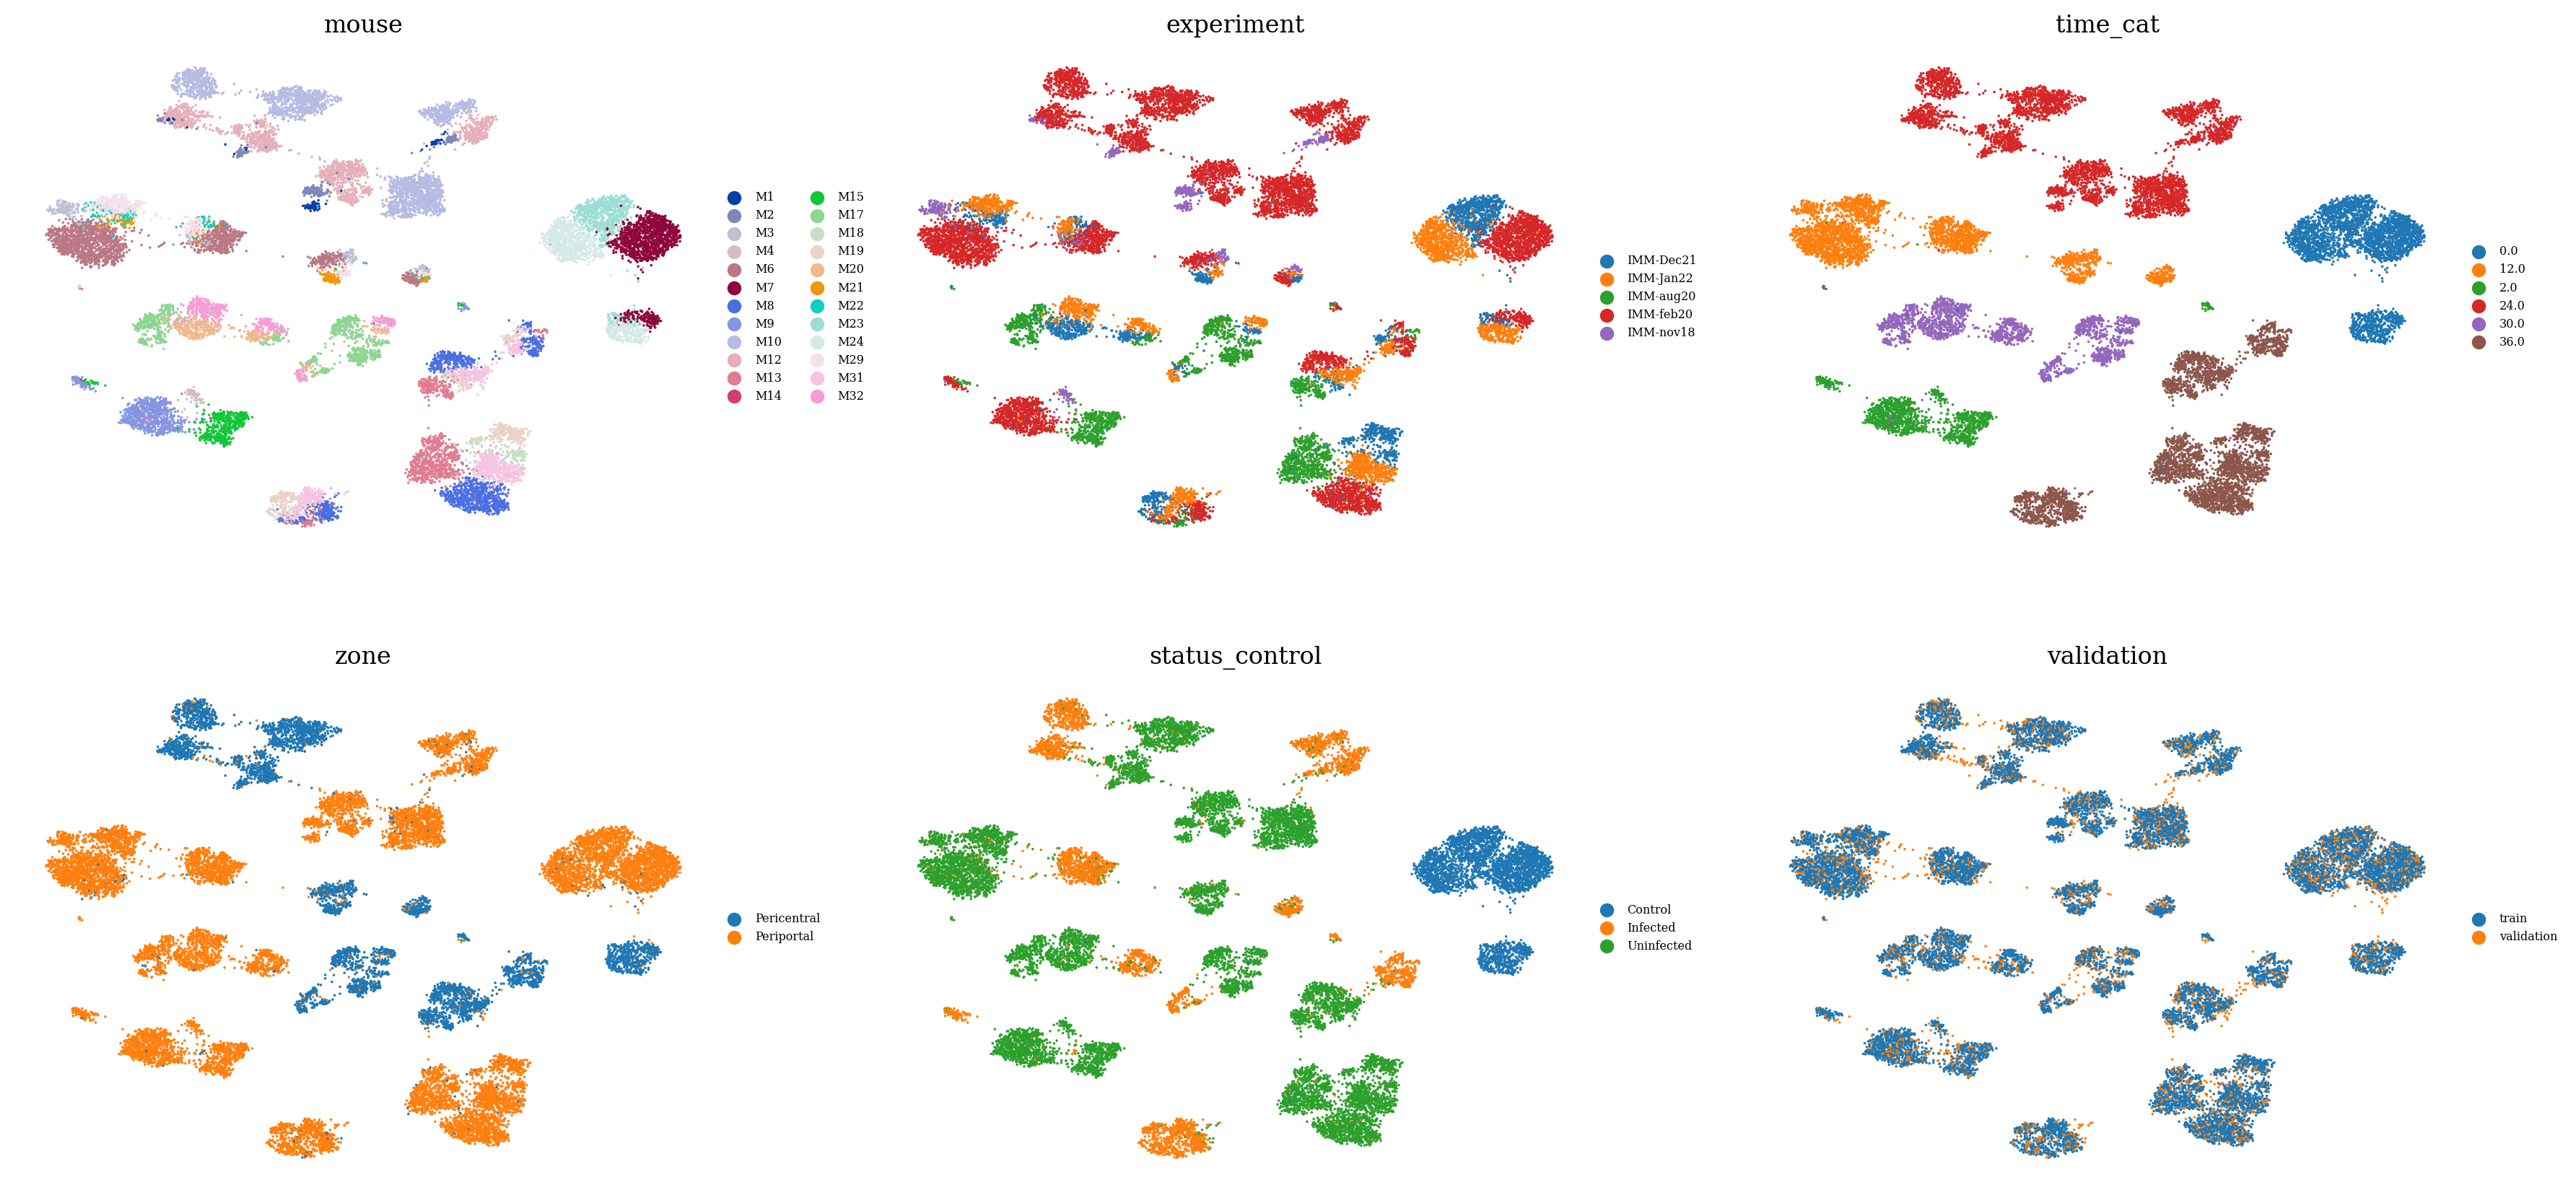

In [14]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [15]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [16]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


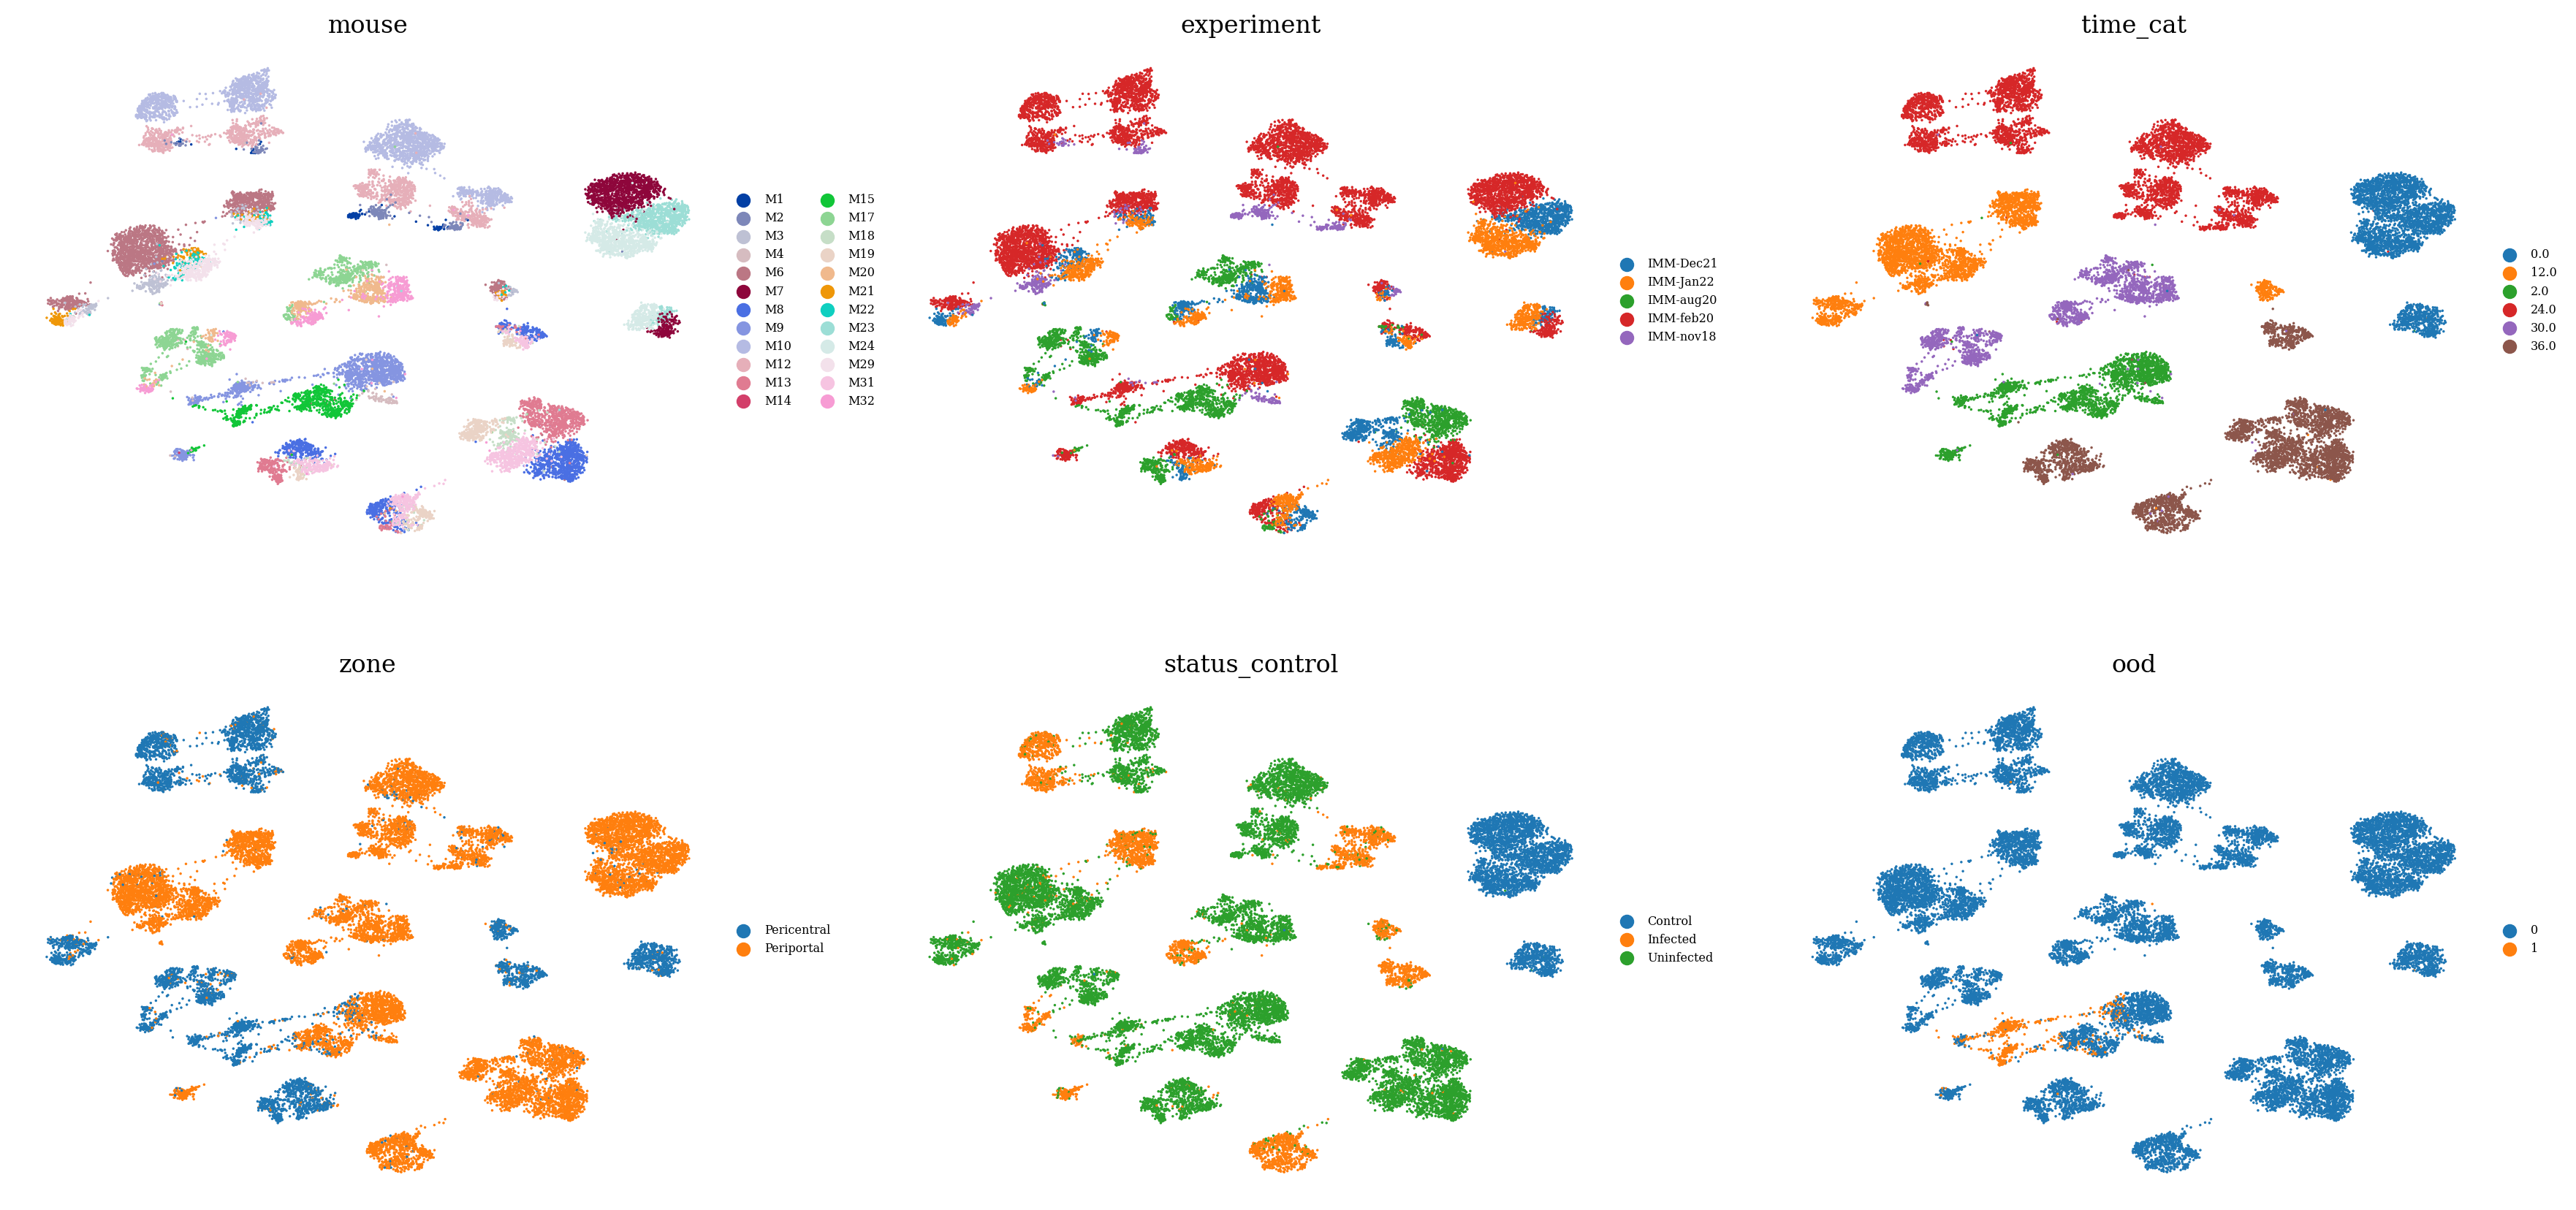

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [18]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45446911247572563
F1 Weighted: 0.4552683215179352



{'accuracy': 0.9250425894378195,
 'precision_macro': 0.3333333333333333,
 'recall_macro': 0.3083475298126065,
 'f1_score_macro': 0.320353982300885,
 'precision_micro': 0.9250425894378195,
 'recall_micro': 0.9250425894378195,
 'f1_score_micro': 0.9250425894378195,
 'precision_weighted': 1.0,
 'recall_weighted': 0.9250425894378195,
 'f1_score_weighted': 0.9610619469026549,
 'confusion_matrix': array([[  0,   0,   0],
        [  0,   0,   0],
        [  1,  43, 543]])}

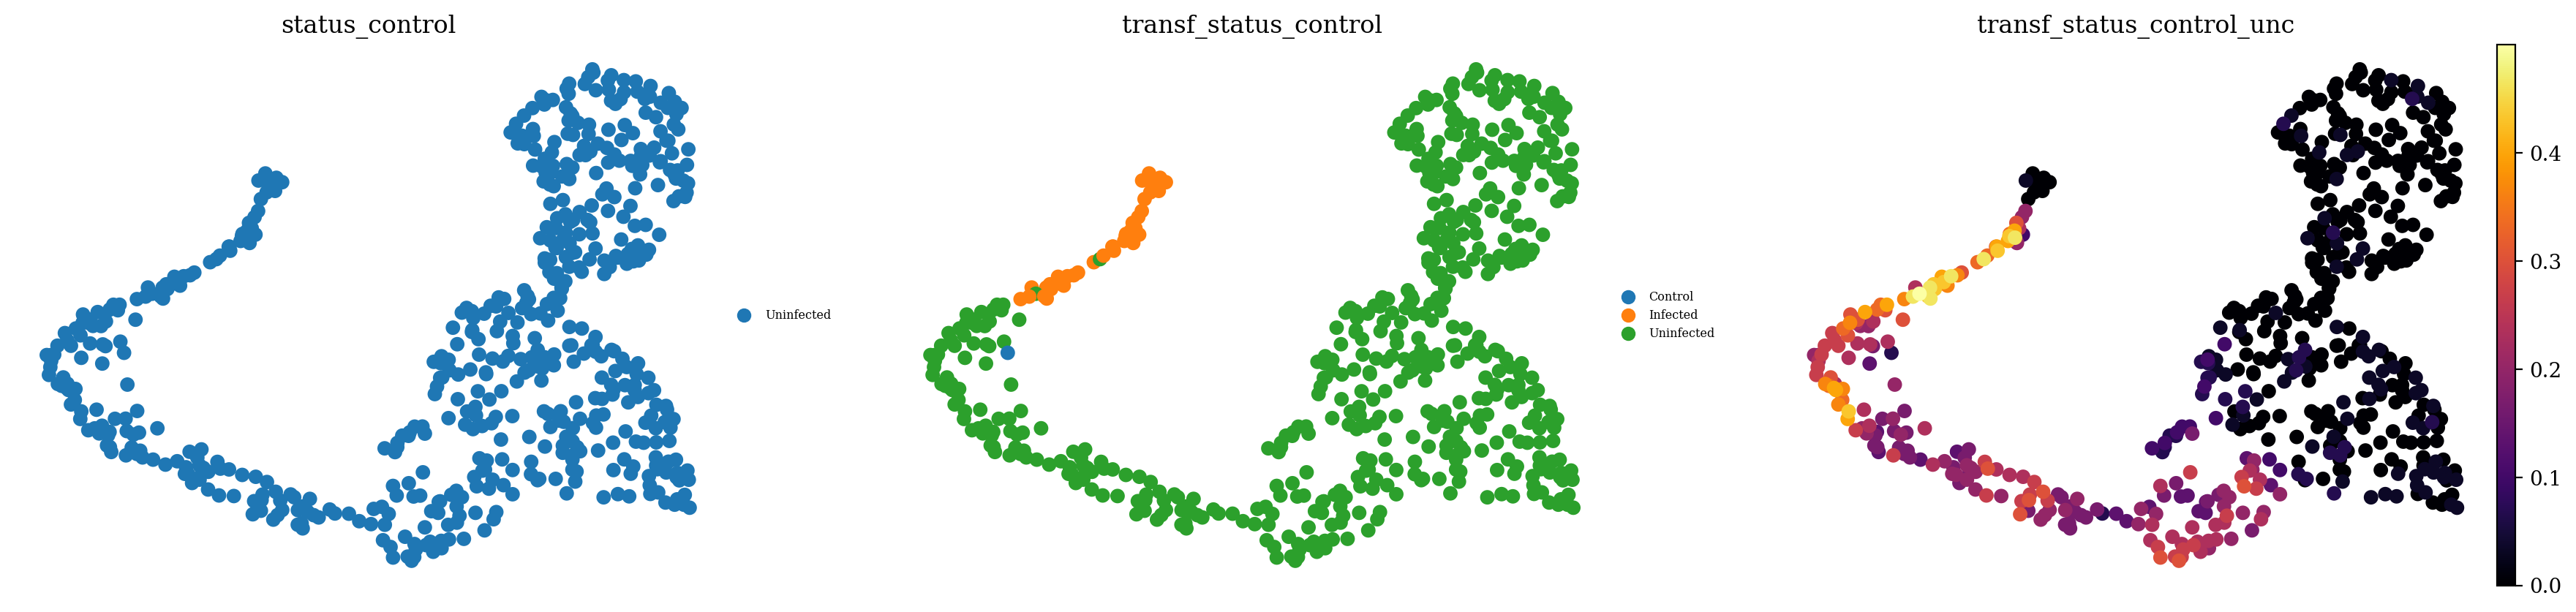

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [20]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata), obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45278958694168897
F1 Weighted: 0.4528162110931036



{'accuracy': 0.868824531516184,
 'precision_macro': 0.3333333333333333,
 'recall_macro': 0.28960817717206133,
 'f1_score_macro': 0.3099361896080219,
 'precision_micro': 0.868824531516184,
 'recall_micro': 0.868824531516184,
 'f1_score_micro': 0.868824531516184,
 'precision_weighted': 1.0,
 'recall_weighted': 0.868824531516184,
 'f1_score_weighted': 0.9298085688240656,
 'confusion_matrix': array([[  0,   0,   0],
        [  0,   0,   0],
        [  1,  76, 510]])}